
    
# I. Introduction


<div style="background:#f0f8ff; padding:12px; border-radius:6px">
Dans ce notebook nous allons faire une analyse textuelle, par catégorie. Nous allons observer les fréquences d'apparition des mots en fonction des catégories. Pour cela nous allons utilisé la fonction clean_text créé (lien doc) dans le notebook text_1a....ypnb qui permet de traiter les mauvais encodage, les entité html de supprimer les balises html.

In [1]:
import regex as reg
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from IPython.display import HTML

import base64
import hashlib

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

import sys
sys.path.insert(0, '../src')
from rakuten_text import clean_text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gabyd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# on charge les données brutes

data_path = "../data/raw/"
df = pd.read_csv(data_path + "X_train_update.csv").drop("Unnamed: 0", axis=1)
y = pd.read_csv(data_path+"Y_train_CVw08PX.csv")["prdtypecode"]
IMG_DIR= data_path+'images/image_train'

# puis on créé les colonnes designation_cleaned et description_cleaned
# qui sont les designation et description "nettoyé"
df['designation_cleaned'] = df['designation'].apply(
    lambda txt : clean_text(txt, fix_encoding=True, unescape_html=True, 
                            normalize_unicode=True, remove_html_tags=True,
                            lowercase=True)
)
df['description_cleaned'] = df['description'].apply(
    lambda txt : clean_text(txt, fix_encoding=True, unescape_html=True, 
                            normalize_unicode=True, remove_html_tags=True,
                            lowercase=True)
)
# On ajoute les catégories au dataframe prétraité
df = pd.concat([df, y], axis=1)

print(df.info())
display(df.head(2))
print(f"La variable cible a {df["prdtypecode"].nunique()} modalités différentes.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84916 entries, 0 to 84915
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   designation          84916 non-null  object
 1   description          55116 non-null  object
 2   productid            84916 non-null  int64 
 3   imageid              84916 non-null  int64 
 4   designation_cleaned  84916 non-null  object
 5   description_cleaned  84916 non-null  object
 6   prdtypecode          84916 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 4.5+ MB
None


designation description   productid  \
0  Olivia: Personalisiertes Notizbuch / 150 Seite...         NaN  3804725264   
1  Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...         NaN   436067568   

      imageid                                designation_cleaned  \
0  1263597046  olivia: personalisiertes notizbuch / 150 seite...   
1  1008141237  journal des arts (le) n° 133 du 28/09/2001 - l...   

  description_cleaned  prdtypecode  
0                               10  
1                             2280

La variable cible a 27 modalités différentes.


# II. Gestion de Doublons

<div style="background:#f0f8ff; padding:12px; border-radius:6px">
Dans un contexte e-commerce, des produits identiques peuvent apparaître plusieurs fois dans le dataset, soit à cause de textes similaires, soit d’images identiques, ou les deux. Pour garantir un corpus propre et exploitable, nous avons d’abord construit le chemin complet vers chaque fichier image à partir des identifiants imageid et productid. Ensuite, chaque image a été convertie en hash SHA1 unique, permettant une comparaison fiable des contenus visuels. Nous avons combiné ces empreintes avec les textes nettoyés (designation_cleaned et description_cleaned) et le code produit (prdtypecode) afin d’identifier et de tagger les doublons complets dans une nouvelle colonne, sans supprimer les produits.
 </div>

In [3]:
df["image_path"] = data_path + "images/image_train/image_" + df['imageid'].astype('str') + "_product_" + df['productid'].astype('str') + ".jpg"

In [4]:
# génère le hashage en fonction d'une liste de chemins
def generate_hash(paths):
    hashed_contents = []
    for path in paths:
        if path is None or not Path(path).exists():  #  Vérifie si le fichier existe
            hashed_contents.append(None)  # Pas de fichier → None
        else:
            with open(path, 'rb') as f:
                # Lire le contenu du fichier et calculer le hash SHA1
                hashed_contents.append(hashlib.sha1(f.read()).hexdigest())
    return hashed_contents
df['hashed_image'] = generate_hash(df['image_path'])

In [5]:
n_duplicates = df[['designation_cleaned', 'description_cleaned', 'hashed_image', 'prdtypecode']].duplicated(keep=False).sum()
print(f"Il y a {n_duplicates} duplicata(s). Ce qui correspond à {round((n_duplicates/len(df))*100, 1)} % des produits.")

Il y a 634 duplicata(s). Ce qui correspond à 0.7 % des produits.


In [6]:
n_duplicata_wdiff_prdtypecode = df[['designation_cleaned', 'description_cleaned', 'hashed_image']].duplicated(keep=False).sum()
print(f"Il y a {n_duplicata_wdiff_prdtypecode} lignes qui ont un doublon sur le texte et l'image mais avec un prdtypecode différent.")

Il y a 653 lignes qui ont un doublon sur le texte et l'image mais avec un prdtypecode différent.


<div style="background:#f0f8ff; padding:12px; border-radius:6px">
La détection identifie 634 doublons, soit 0.7 % des produits. Il y a également 20 cas pour lesquels d'autres entrées ont des textes et des images identiques mais qui ne sont pas des doublons car ils sont indiqué dans des catégories différentes. Comme les données sont brutes, les données proviennent directement du site de Rakuten, ce n'est pas étonnant de retrouver des produits mal labelisé. (les mauvais labels seront traité dans le notebook xxxx)

<div style="background:#f0f8ff; padding:12px; border-radius:6px">Pour garder une traçabilité complète et permettre une future analyse ou inspection manuelle, nous avons ajouté une colonne is_duplicated_full. Cette colonne marque chaque ligne comme True si elle possède un doublon exact, et False si elle est unique.

In [7]:
#Tagger les duplicatas
df['is_duplicated_full'] = df.duplicated(
    subset=['designation_cleaned', 'description_cleaned', 'hashed_image', 'prdtypecode'], 
    keep='first'
)



# III. Labellisation intelligible des catégories par observation visuelle



<div style="background:#f0f8ff; padding:12px; border-radius:6px">
Dans le cadre de la labellisation intelligible des catégories par observation visuelle, nous avons d’abord généré pour chaque produit le chemin complet menant à son image, en combinant les identifiants imageid et productid. Cette opération permet d’associer explicitement chaque ligne du dataframe à son fichier image correspondant dans le dossier image_train.
Nous avons ensuite mis en place une fonction convertissant les fichiers images en code base64 afin de pouvoir les afficher directement dans le notebook. Enfin, nous avons affiché un échantillon de produits en juxtaposant leurs informations textuelles nettoyées et leurs images. Cette prévisualisation permet de vérifier la cohérence entre les textes et les visuels, condition essentielle pour mener une labellisation des catégories.


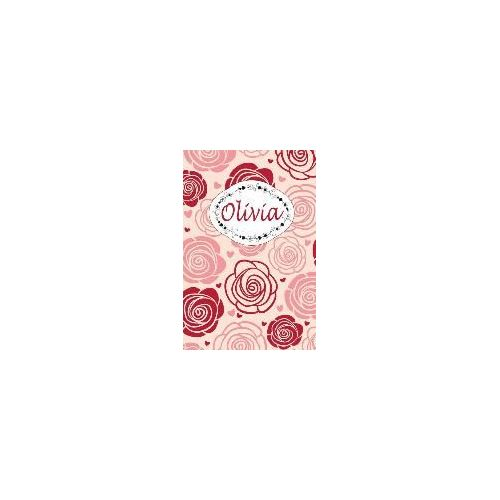
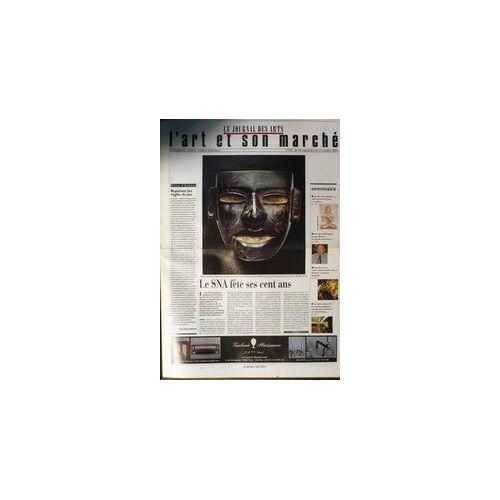

In [9]:
# Fonction pour convertir une image locale en base64
def afficher_image(chemin, taille=126):
    """Convertit une image en HTML base64 pour l'affichage."""
    if not chemin or not Path(chemin).exists():
        return ""
    b64 = base64.b64encode(Path(chemin).read_bytes()).decode("ascii")
    return f'<img src="data:image/jpeg;base64,{b64}" width="{taille}" />'

# Colonnes à afficher 
colonnes_a_afficher = ["prdtypecode", "designation_cleaned", "image_path"]
colonnes_disponibles = [col for col in colonnes_a_afficher if col in df.columns]

# Création d’un petit échantillon avec les images 
vue = df[colonnes_disponibles].head(2).copy()
vue["image"] = vue["image_path"].apply(afficher_image)

# Affichage final 
display(HTML(vue.drop(columns=["image_path"]).to_html(escape=False, index=True)))


<div style="background:#f0f8ff; padding:12px; border-radius:6px"> Pour pouvoir donner un nom clair et intelligible à chacune des catégories, nous avons procédé à l’observation visuelle de tous les codes prdtypecode présents dans le dataset. Pour chaque catégorie, nous avons filtré les produits correspondants et examiné les premières entrées du dataframe.

L’inspection a été réalisée à la fois sur les images des produits et sur le contenu textuel des colonnes designation et description nettoyées. Cette analyse nous a permis de comprendre la nature et la cohérence de chaque catégorie et de proposer des noms pertinents et représentatifs pour toutes les catégories.

Nombre de produits dans la catégorie 10 : 3116



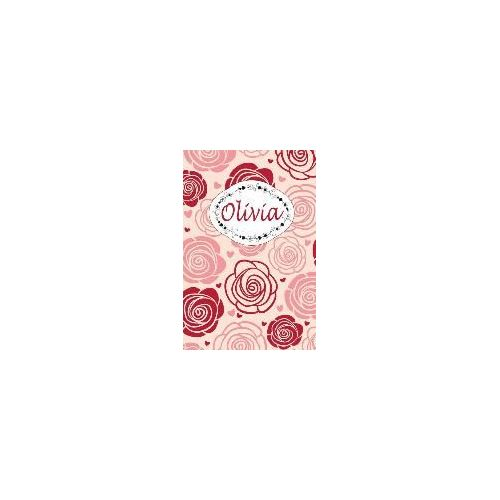
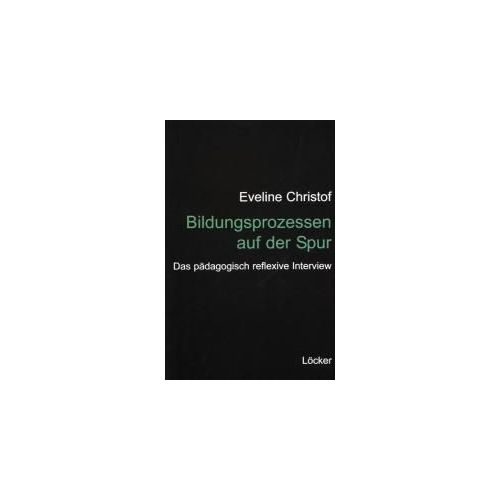
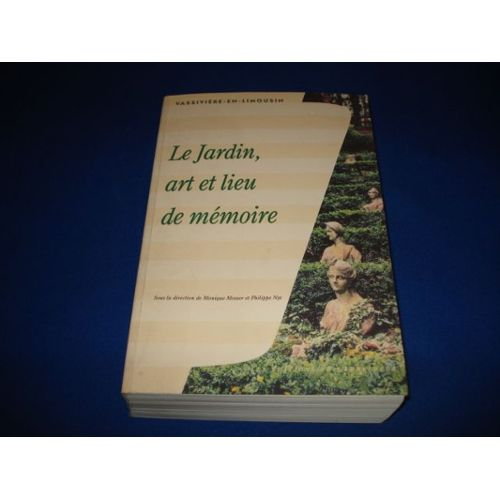
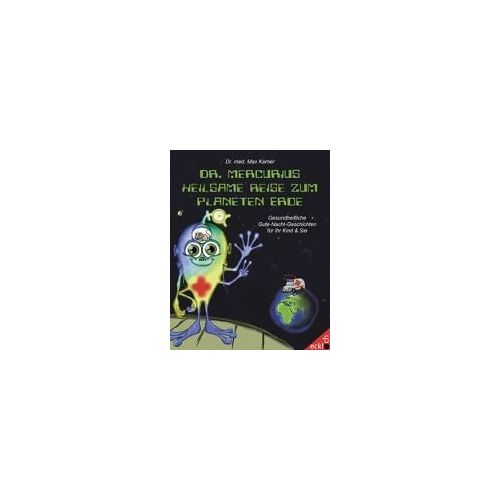
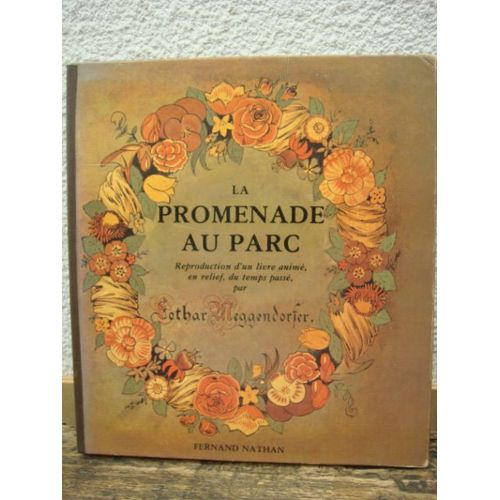

In [10]:
# Sélection de la catégorie à observer 
cat = 10  
df_cat = df[df["prdtypecode"] == cat].copy()

print(f"Nombre de produits dans la catégorie {cat} :", len(df_cat))

# Colonnes pertinentes pour l’observation 
colonnes = ["prdtypecode", "designation_cleaned", "description_cleaned", "image_path"]
colonnes = [c for c in colonnes if c in df_cat.columns]

# Création d’un échantillon visuel des premiers produits 
echantillon = df_cat[colonnes].head(5).copy()   # Affiche 5 produits
echantillon["image"] = echantillon["image_path"].apply(afficher_image)

# Affichage final : textes + images 
display(HTML(
    echantillon.drop(columns=["image_path"]).to_html(escape=False, index=True)
))


<div style="background:#f0f8ff; padding:12px; border-radius:6px"> Par exemple, la catégorie 10 semble représenter des livres. En procédant de la même manière pour chaque catégorie, nous avons pu identifier les types de produits regroupés et attribuer un nom approprié.

Nous allons maintenant donner un nom aux catégories identifiées dans la colonne categories, noms qui pourront ensuite être affinés et validés à l’aide des nuages de mots générés sur l’ensemble des produits de chaque catégorie, assurant ainsi une labellisation robuste et intelligible.

In [23]:
categories = {
    "Livres & Revues": {
        "Livres spécialisés": 10,
        "Littérature": 2705,
        "Presse & Magazines": 2280,
        "Séries & Encyclopédies": 2403,
    },

    "Jeux Vidéo": {
        "Rétro Gaming": 40,
        "Accessoires & Périphériques": 50,
        "Consoles": 60,
        "Jeux Vidéo Modernes": 2462,
        "Jeux PC en Téléchargement": 2905,
    },

    "Collection": {
        "Figurines": 1140,
        "Jeux de cartes": 1160,
        "Jeux de rôle & Figurines": 1180,
    },

    "Jouets, Jeux & Loisirs": {
        "Jouets & Figurines": 1280,
        "Jeux éducatifs": 1281,
        "Modélisme & Drones": 1300,
        "Loisirs & Plein air": 1302,
    },

    "Bébé": {
        "Vêtement Bébé & Loisirs": 1301,
        "Puériculture": 1320,
    },

    "Maison": {
        "Équipement Maison": 1560,
        "Textiles d'intérieur": 1920,
        "Décoration & Lumières": 2060,
    },

    "Jardin & Extérieur": {
        "Décoration & Équipement Jardin": 2582,
        "Piscine & Accessoires": 2583,
        "Bricolage & Outillage": 2585,
    },

    "Autres": {
        "Épicerie": 1940,
        "Animaux": 2220,
        "Bureau & Papeterie": 2522,
    }
}

groups_mapper = {}
categories_mapper = {}
for group, g_categories in categories.items():
    for cat, code in g_categories.items():
        groups_mapper[code] = group
        categories_mapper[code] = cat

df['category'] = df['prdtypecode'].replace(categories_mapper)
df['group'] = df['prdtypecode'].replace(groups_mapper)

<div style="background:#f0f8ff; padding:12px; border-radius:6px"> Après avoir attribué un nom explicite à chaque prdtypecode, nous avons organisé ces catégories en groupes plus larges (ex. « Livres & Revues », « Jeux Vidéo », « Maison ») pour faciliter l’analyse.
Le dataframe contient désormais :
    
- la colonne category, avec le nom de chaque catégorie,
- la colonne group, regroupant les catégories similaires sous un label global.

Cette structuration permet une vision synthétique du catalogue tout en conservant la traçabilité des codes produits originaux.



# IV. Distribution des produits par catégorie


<div style="background:#f0f8ff; padding:12px; border-radius:6px"> Dans le chapitre précédent, nous avons attribué des noms intelligibles aux catégories et aux groupes de produits, en nous basant sur l’observation visuelle des images et des textes associés. Dans ce chapitre, nous allons explorer la distribution des articles à travers ces nouvelles catégories et groupes. L’objectif est de comprendre la répartition des produits dans le dataset, d’identifier les catégories majoritaires et minoritaires, et de visualiser comment les groupes plus larges regroupent les différents types de produits.

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h3 align="left">4.1 Affichage du nombre d'articles par catégories</h3>

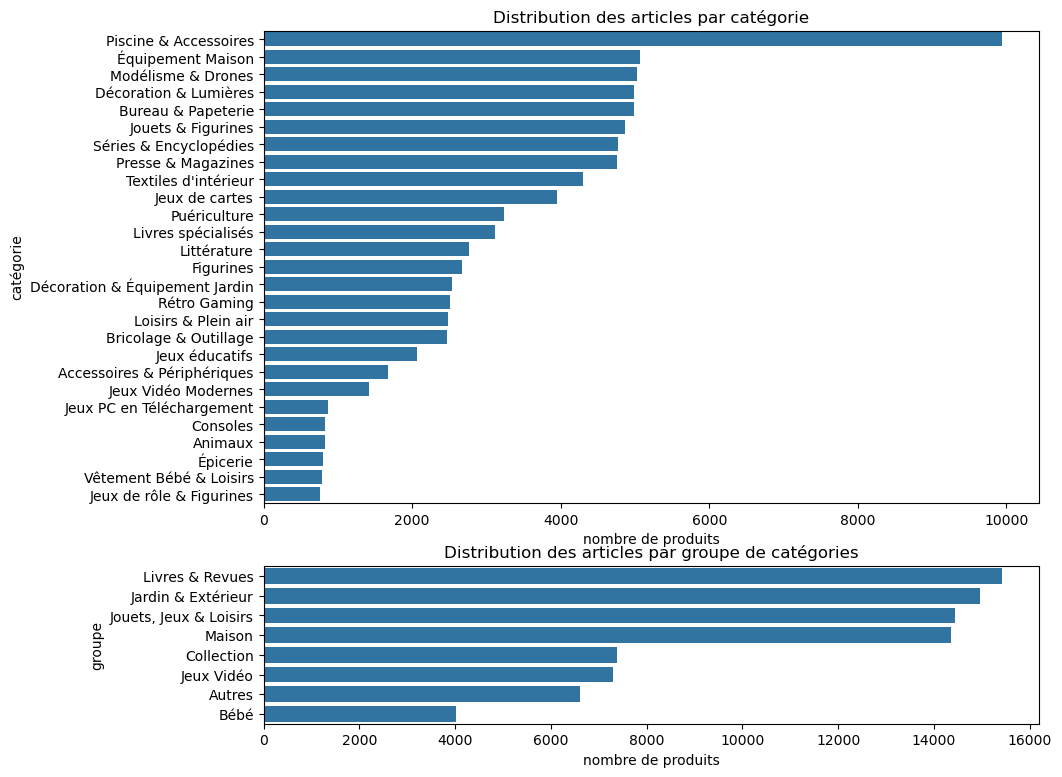

La catégorie la plus représentée est Piscine & Accessoires.
Elle à  13.0  fois plus d'articles que la catégorie Jeux de rôle & Figurines qui est la moins représentée.




In [28]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,9), gridspec_kw={"height_ratios": [3, 1]})

cat_counts = df['category'].value_counts()
sns.barplot(x=cat_counts.values, y=cat_counts.index, ax=ax1)
ax1.set_ylabel('catégorie')
ax1.set_xlabel('nombre de produits')
ax1.set_title('Distribution des articles par catégorie')

group_counts = df['group'].value_counts()
sns.barplot(x=group_counts.values, y=group_counts.index, ax=ax2)
ax2.set_ylabel('groupe')
ax2.set_xlabel('nombre de produits')
ax2.set_title('Distribution des articles par groupe de catégories')

plt.show()

print(
    f"La catégorie la plus représentée est {cat_counts.index[0]}.\nElle à ",
    round(cat_counts.iloc[0]/cat_counts.iloc[-1],1),
    f" fois plus d'articles que la catégorie {cat_counts.index[-1]} qui est la moins représentée.\n\n"
)

<div style="background:#f0f8ff; padding:12px; border-radius:6px"> On observe que la catégorie la plus représentée est Piscine & Accessoires, avec 13 fois plus d’articles que la catégorie Jeux de rôle & Figurines, qui est la moins représentée. Cette observation met en évidence un déséquilibre important dans le jeu de données, ce qui rend crucial un échantillonnage stratifié lors des splits entraînement / validation. En effet, sans stratification, certaines classes risqueraient d’être trop peu présentes, ce qui pourrait nuire à la performance des modèles ou fausser l’évaluation, car certaines catégories seraient sous-représentées ou sur-représentées.

Par ailleurs, dans le prémier notebook, nous avions déjà constaté qu’environ 35 % des produits ne disposent pas de description. Il est donc pertinent de vérifier si ces absences sont uniformément réparties entre les catégories ou si certaines classes sont davantage touchées. Cette étape permettra d’anticiper les biais potentiels et d’adapter notre traitement des données avant l’entraînement des modèles.

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h3 align="left">4.2 Observation de la proportion des produits sans description par catégorie</h3> 

<div style="background:#f0f8ff; padding:12px; border-radius:6px"> La visualisation ci-dessus permet d’identifier les catégories et groupes les plus concernés par l’absence de descriptions. On observe que certaines catégories présentent une proportion notablement plus élevée de produits sans description, tandis que d’autres sont quasiment complètes

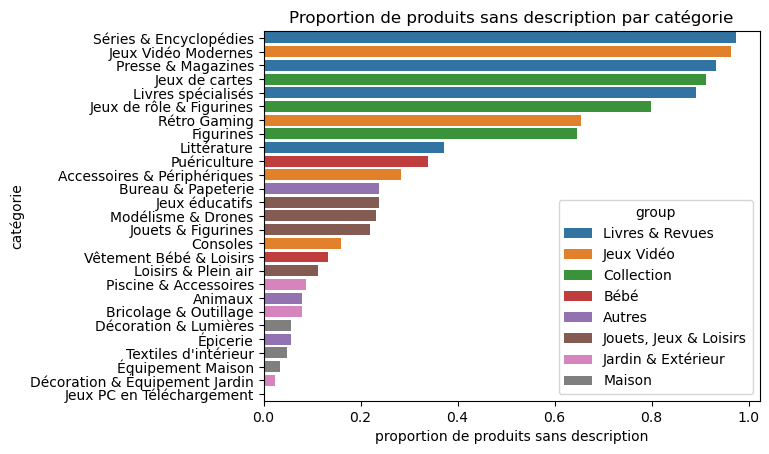

In [32]:
na_rates = df[df['description'].isna()][['group', 'category']].value_counts() / df[['group', 'category']].value_counts()
na_rates = na_rates.fillna(0).sort_values(ascending=False).reset_index()
sns.barplot(data=na_rates, x='count', y='category', hue='group')
plt.xlabel("proportion de produits sans description")
plt.ylabel("catégorie")
plt.title('Proportion de produits sans description par catégorie');

<div style="background:#f0f8ff; padding:12px; border-radius:6px">Ici, on remarque que certains groupes de catégories, comme les Livres et Revues, comportent un grand nombre de produits sans description, tandis que d’autres, comme les Équipements de la Maison, contiennent généralement du texte descriptif. Cela semble cohérent : en général, le titre d’un livre suffit pour identifier le produit, alors que pour les équipements, une description détaillée est souvent nécessaire pour préciser les dimensions ou les caractéristiques techniques.

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h3 align="left">4.3 Observation de la longueur moyenne des descriptions par catégorie</h3> 

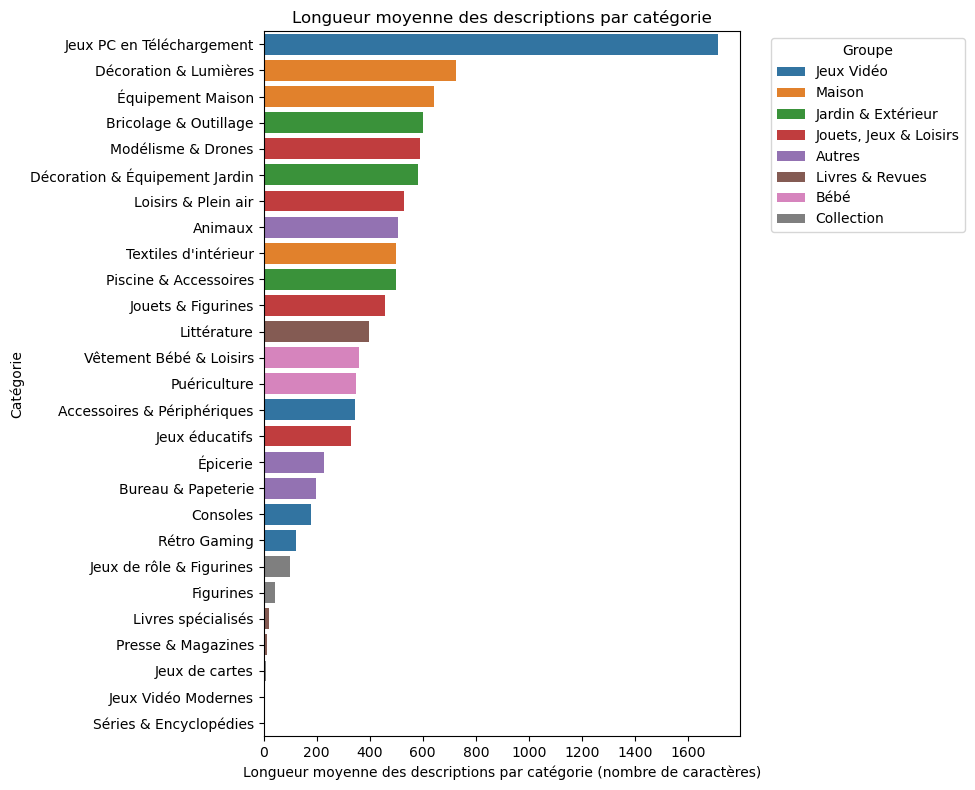

In [35]:
# Calculer la longueur de chaque description nettoyée 
# Si la description est vide ou NaN, on met 0
df["description_cleaned_len"] = df["description_cleaned"].apply(lambda x: len(x) if isinstance(x, str) else 0)

# Longueur moyenne des descriptions par groupe et catégorie 
len_means = (
    df.groupby(['group', 'category'])["description_cleaned_len"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

# Graphique en barres 
plt.figure(figsize=(10,8))
sns.barplot(
    data=len_means,
    x='description_cleaned_len',
    y='category',
    hue='group'
)
plt.xlabel("Longueur moyenne des descriptions par catégorie (nombre de caractères)")
plt.ylabel("Catégorie")
plt.title("Longueur moyenne des descriptions par catégorie")
plt.legend(title='Groupe', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


<div style="background:#f0f8ff; padding:12px; border-radius:6px">En analysant la longueur moyenne des descriptions par catégorie, on remarque que certaines groupes, comme les Livres & Revues, contiennent souvent très peu de texte, voire pas de description. À l’inverse, les catégories liées aux équipements, comme Maison ou Décoration & Lumières, possèdent des descriptions plus détaillées, nécessaires pour préciser les dimensions ou caractéristiques des produits.

On note également que les jeux PC en téléchargement se distinguent par des descriptions particulièrement longues, dépassant en moyenne 2 000 caractères, ce qui reflète l’importance de fournir des informations complètes aux acheteurs pour ce type de produits.

# V - Caractérisation quantitative des catégories par analyse discriminante

<div style="background:#f0f8ff; padding:12px; border-radius:6px"> Cette section a pour objectif de quantifier et comparer les catégories de produits à partir de leurs descriptions textuelles. Nous combinons une approche exploratoire visuelle et une analyse statistique des mots-clés afin de comprendre quels termes discriminent chaque groupe et chaque catégorie.

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

### 5.1 Exploration thématique par nuages de mots</span>



<div style="background:#f0f8ff; padding:12px; border-radius:6px"> Pour approfondir la labellisation des groupes de produits, nous procédons à une exploration thématique via des nuages de mots.

1. Vectorisation des textes : nous utilisons TfidfVectorizer pour transformer le texte de chaque produit en vecteurs numériques pondérés par importance (TF-IDF). Les mots très fréquents mais peu informatifs sont retirés grâce à une liste de stop words, et les n-grammes (1 et 2 mots) sont pris en compte pour capturer des expressions significatives.

2. Analyse par groupe et catégorie : pour chaque groupe de produits, nous calculons la fréquence moyenne des termes dans toutes les descriptions, puis nous séparons par catégorie. Cela nous permet d’identifier les mots les plus représentatifs de chaque ensemble de produits.

3. Visualisation via des nuages de mots : chaque groupe et chaque catégorie est représenté par un nuage de mots, où la taille des mots reflète leur importance dans les descriptions. La fonction images_grid permet d’afficher ces nuages sous forme de grille, facilitant la comparaison visuelle entre les catégories d’un même groupe.

In [41]:
def images_grid(images, nrows=5, ncols=10, cmap=None, titles=None, ordered_by_rows=True, axes_size=(1.5, 1.5)):
    fig, axes = plt.subplots(nrows, ncols, figsize=(axes_size[0]*ncols, axes_size[1]*nrows), squeeze=False)
    axes = axes.flatten()
    if ordered_by_rows:
        axes_order = range(nrows*ncols)
    else:
        axes_order = [i*ncols + j for j in range(ncols) for i in range(nrows)]
    for i in range(nrows*ncols):
        k = axes_order[i]
        if i < len(images):
            axes[k].imshow(images[i], cmap=cmap)
            if titles:
                axes[k].set_title(titles[i], fontsize=8)
        axes[k].set_xticks([])
        axes[k].set_yticks([])
    plt.show()

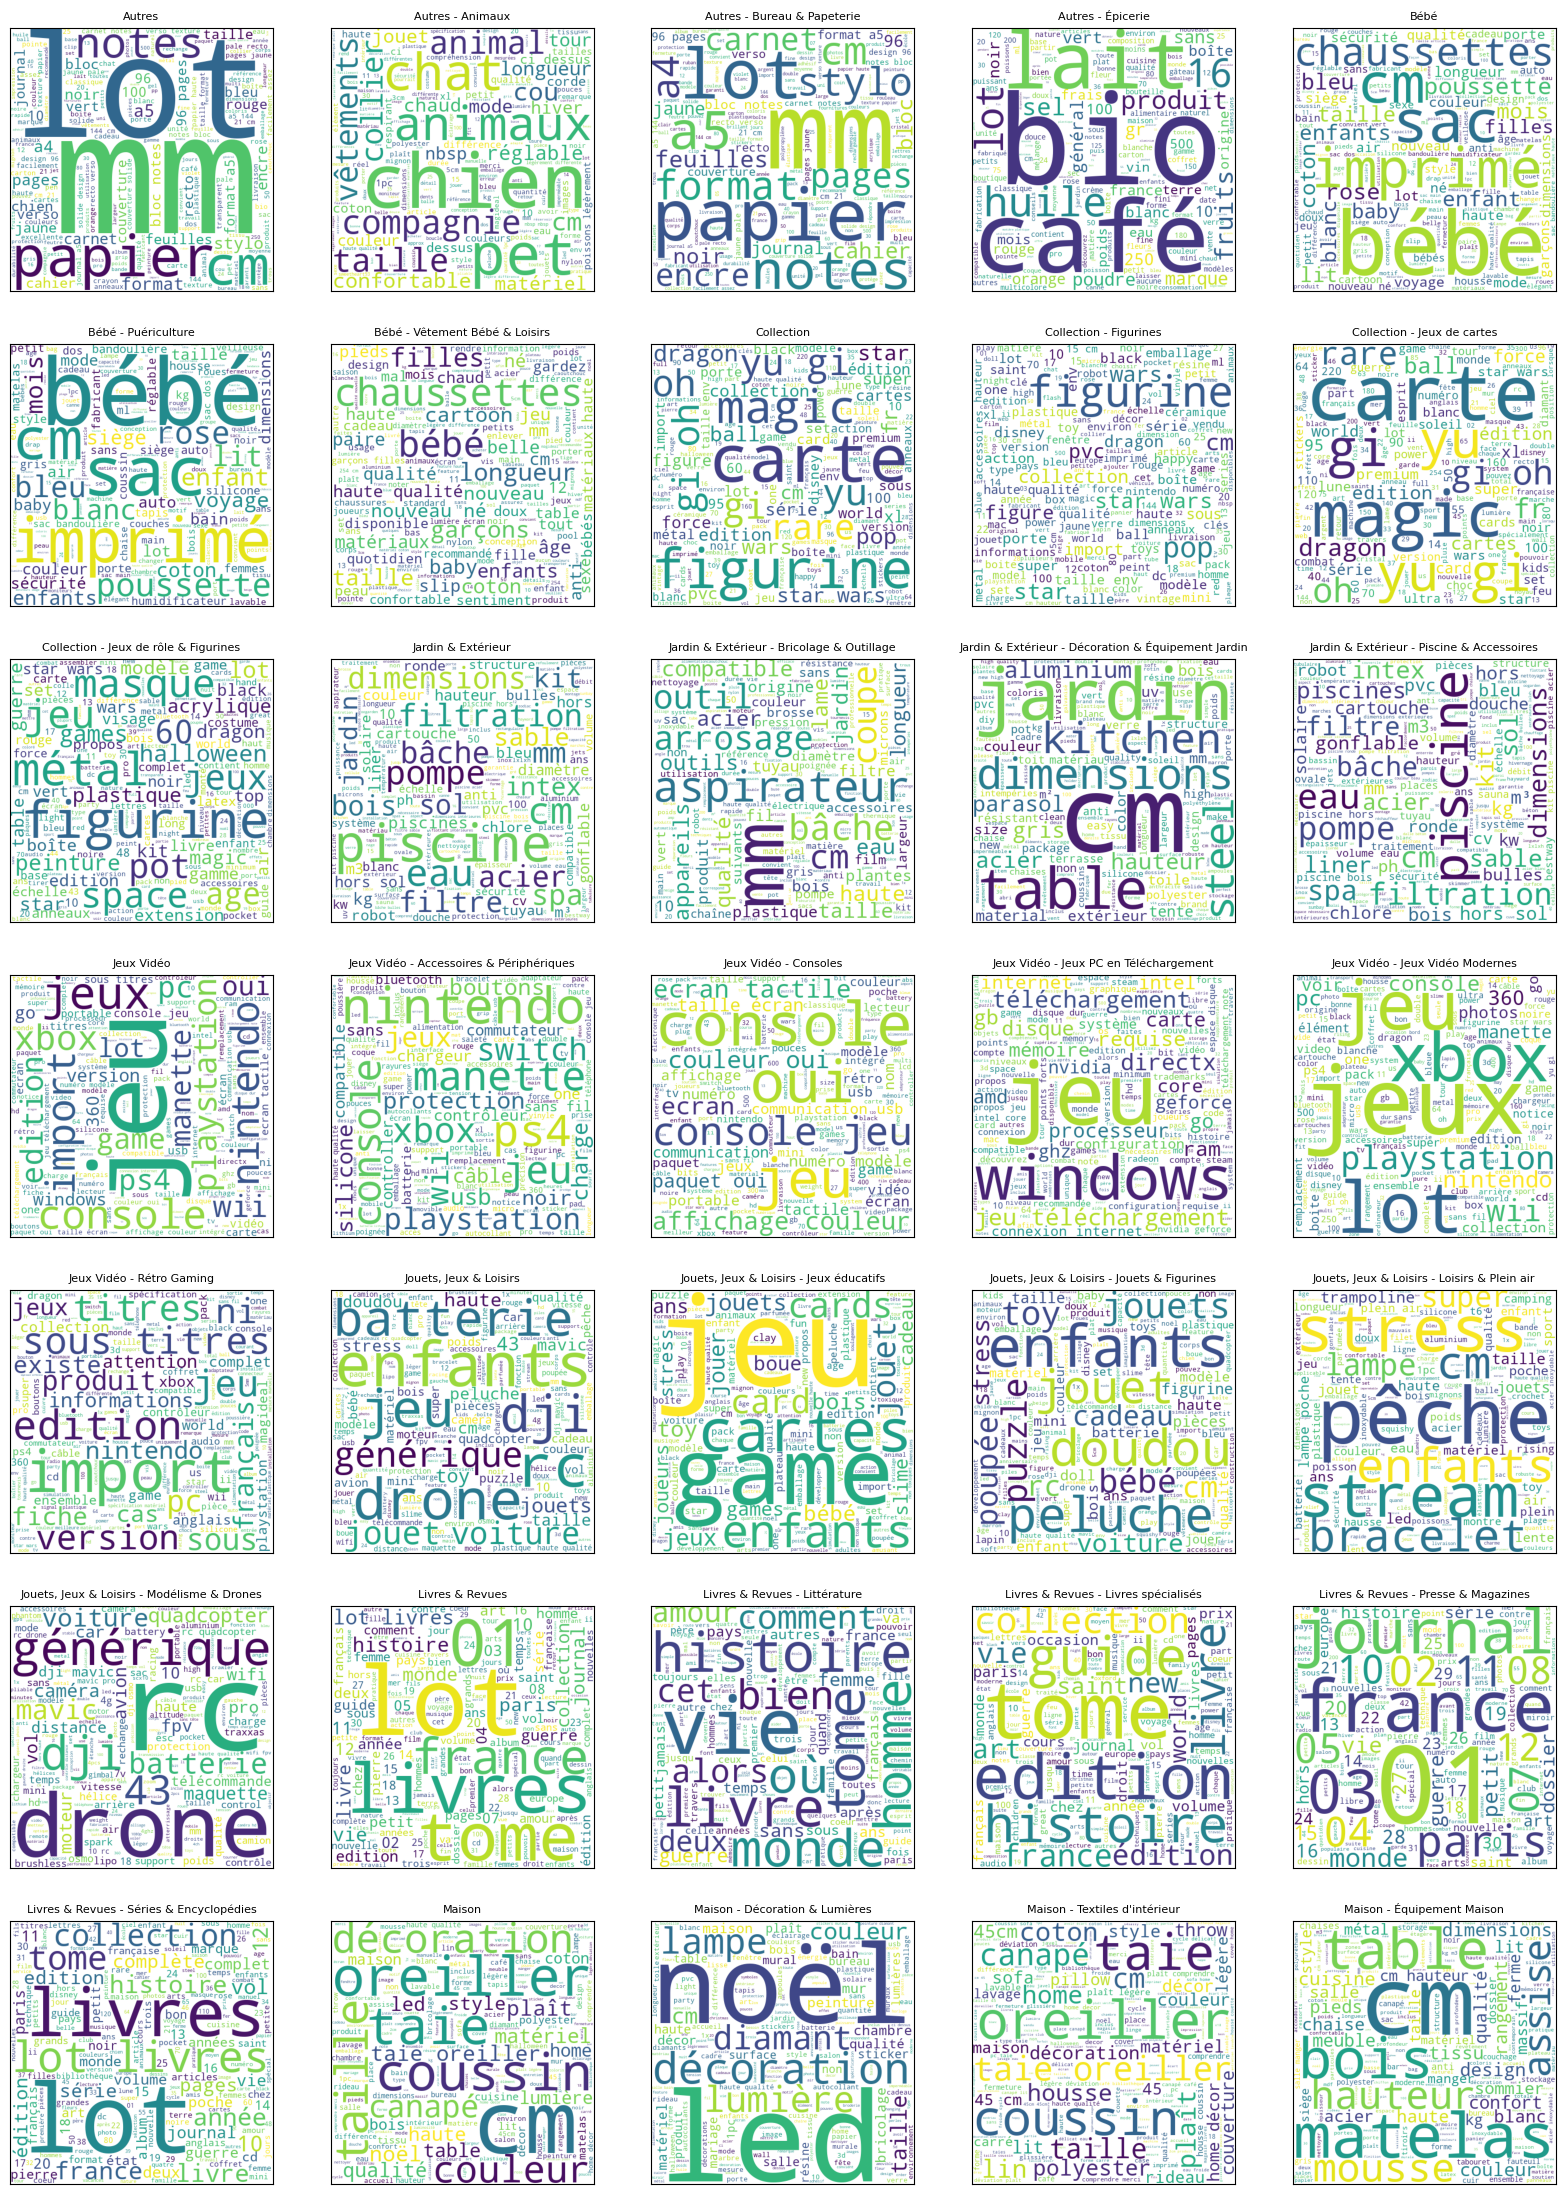

In [42]:

# Stopwords en 4 langues : anglais, français, allemand, néerlandais
stop_words = (
    set(stopwords.words('english'))
    | set(stopwords.words('french'))
    | set(stopwords.words('german'))
    | set(stopwords.words('dutch'))
)

vectorizer = TfidfVectorizer(
    max_features=2000,
    stop_words=list(stop_words),
    ngram_range=(1,2)
)
# Transformation TF-IDF
tfidf_matrix = vectorizer.fit_transform(df['text_cleaned'].fillna(''))
tfidf = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=vectorizer.get_feature_names_out(),
    index=df.index
)
# Stockage des fréquences 
freqs = {}
groups = sorted(df["group"].unique())
for gr in groups:
    mask = df["group"] == gr
    gr_cats = sorted(df[mask]["category"].unique())
    freqs[gr] = tfidf[mask].mean().sort_values(ascending=False)
    for cat in gr_cats:
        mask = df["category"] == cat
        freqs[f"{gr} - {cat}"] = (
            tfidf[mask]
            .mean()
            .sort_values(ascending=False)
        )
    # Génération des nuages de mots
wc = [
    WordCloud(width=500, height=500, background_color="white")
    .generate_from_frequencies(f)
    for f in freqs.values()
]
images_grid(wc, 7, 5, titles=list(freqs), axes_size=(4,4)) 



<div style="background:#f0f8ff; padding:12px; border-radius:6px">Cette étape valide et affine les noms de catégories et de groupes identifiés précédemment, en donnant un aperçu rapide et intuitif du contenu thématique des produits. Par exemple, pour le groupe Livres & Revues, les mots dominants confirment la présence de livres spécialisés, de littérature et de presse, tandis que pour le groupe Jeux Vidéo, on distingue clairement les consoles, les accessoires et les jeux modernes.

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

### 5.2 Validation des catégories par fréquence de mots-clés









<div style="background:#f0f8ff; padding:12px; border-radius:6px">Après avoir exploré visuellement les mots les plus fréquents dans chaque groupe via les nuages de mots, nous souhaitons maintenant quantifier la présence de certains mots-clés importants. Le heatmap permet de voir, pour chaque groupe ou catégorie, la proportion de produits contenant ces mots-clés, ce qui complète l’analyse visuelle.
Par exemple, nous pouvons rapidement constater que certains mots comme “bébé” apparaissent presque exclusivement dans le groupe “Bébé”, tandis que “piscine” est spécifique au groupe “Jardin & Extérieur”. Cela permet de confirmer la cohérence des catégories et d’identifier les termes caractéristiques de chaque groupe, ce qui sera utile pour valider la labellisation des catégories.

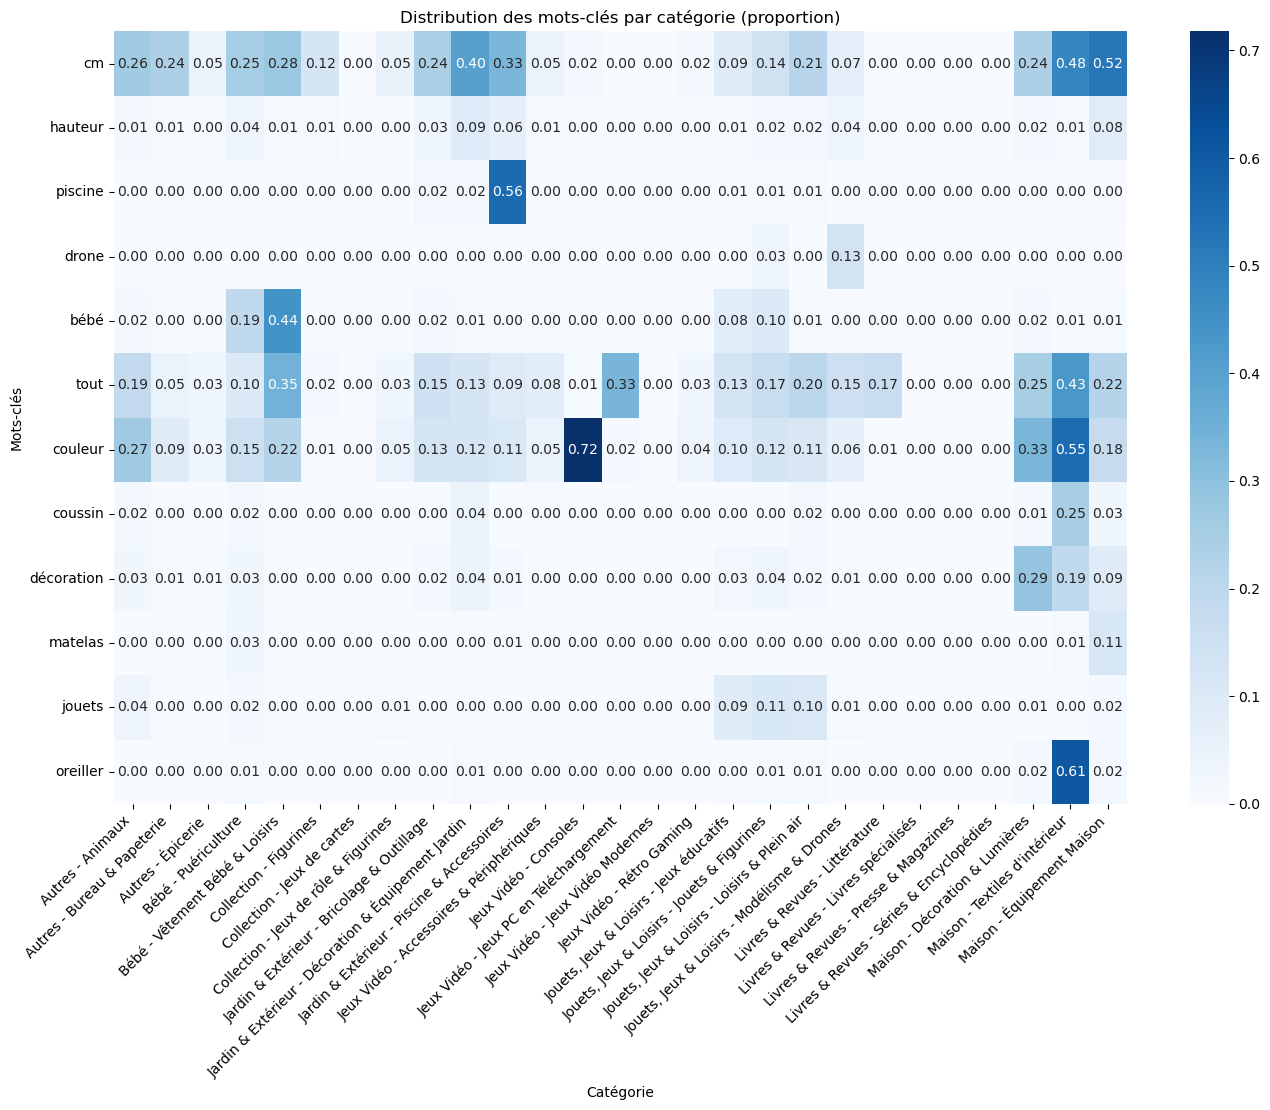

Unnamed: 0                                        designation  \
0               0  Olivia: Personalisiertes Notizbuch / 150 Seite...   
1               1  Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...   
2               2  Grand Stylet Ergonomique Bleu Gamepad Nintendo...   
3               3  Peluche Donald - Europe - Disneyland 2000 (Mar...   
4               4                               La Guerre Des Tuques   
...           ...                                                ...   
84911       84911                        The Sims [ Import Anglais ]   
84912       84912  Kit piscine acier NEVADA déco pierre Ø 3.50m x...   
84913       84913  Journal Officiel De La Republique Francaise N°...   
84914       84914  Table Basse Bois De Récupération Massif Base B...   
84915       84915  Gomme De Collection 2 Gommes Pinguin Glace Ver...   

                                             description   productid  \
0                                                    NaN  3804725264   
1                                                    NaN   436067568   
2      PILOT STYLE Touch Pen de marque Speedlink est ...   201115110   
3                                                    NaN    50418756   
4      Luc a des id&eacute;es de grandeur. Il veut or...   278535884   
...                                                  ...         ...   
84911                                                NaN   206719094   
84912  <b>Description complète :</b><br />Kit piscine...  3065095706   
84913                                                NaN   440707564   
84914  <p>Cette table basse a un design unique et con...  3942400296   
84915                                                NaN    57203227   

          imageid                                               text  \
0      1263597046  Olivia: Personalisiertes Notizbuch / 150 Seite...   
1      1008141237  Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...   
2       938777978  Grand Stylet Ergonomique Bleu Gamepad Nintendo...   
3       457047496  Peluche Donald - Europe - Disneyland 2000 (Mar...   
4      1077757786  La Guerre Des Tuques Luc a des id&eacute;es de...   
...           ...                                                ...   
84911   941495734                       The Sims [ Import Anglais ]    
84912  1188462883  Kit piscine acier NEVADA déco pierre Ø 3.50m x...   
84913  1009325617  Journal Officiel De La Republique Francaise N°...   
84914  1267353403  Table Basse Bois De Récupération Massif Base B...   
84915   684671297  Gomme De Collection 2 Gommes Pinguin Glace Ver...   

                                            text_cleaned  \
0      olivia: personalisiertes notizbuch 150 seiten ...   
1      journal arts (le) n° 133 28/09/2001 l'art marc...   
2      stylet ergonomique bleu gamepad nintendo wii s...   
3      peluche donald europe disneyland 2000 (marionn...   
4      guerre tuques luc idées grandeur veut organise...   
...                                                  ...   
84911                                sims import anglais   
84912  kit piscine acier nevada déco pierre 3.50m 0.9...   
84913  journal officiel republique francaise n° 46 15...   
84914  table basse bois récupération massif base blan...   
84915  gomme collection gommes pinguin glace vert orange   

                                     designation_cleaned  \
0      olivia: personalisiertes notizbuch 150 seiten ...   
1      journal arts (le) n° 133 28/09/2001 l'art marc...   
2      stylet ergonomique bleu gamepad nintendo wii s...   
3      peluche donald europe disneyland 2000 (marionn...   
4                                          guerre tuques   
...                                                  ...   
84911                                sims import anglais   
84912   kit piscine acier nevada déco pierre 3.50m 0.90m   
84913  journal officiel republique francaise n° 46 15...   
84914  table basse bois récupération massif base blan...   
84915  gomme collection gommes 

In [46]:
import re

def plot_keywords_heatmap(df, keywords, text_col="text", by="prdtypecode"):
    category_codes = sorted(df[by].unique())
    result = pd.DataFrame(index=keywords, columns=category_codes, dtype=float)
    for kw in keywords:
        pattern = fr"\b{re.escape(kw)}\b"
        contains_kw = df[text_col].astype(str).str.contains(pattern, na=False)
        freq = contains_kw.groupby(df[by]).mean()
        result.loc[kw, freq.index] = freq.values
    col_labels = [categories.get(code, str(code)) for code in category_codes]
    result_for_plot = result.copy()
    result_for_plot.columns = col_labels
    plt.figure(figsize=(14, len(keywords) * 0.6 + 4))
    sns.heatmap(result_for_plot.astype(float), annot=True, fmt=".2f", cmap="Blues")
    plt.title("Distribution des mots-clés par catégorie (proportion)")
    plt.xlabel("Catégorie")
    plt.ylabel("Mots-clés")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


keywords = [ #"temp", "vidéo", "!",
    "cm", "hauteur",
    "piscine", "drone", "bébé", "tout",
    # "led", "&",
    "couleur",
    "coussin", "décoration", "matelas", "jouets", "oreiller"
]
df['group_cat'] = df['group'] + ' - ' + df['category']
plot_keywords_heatmap(df, keywords, by='group_cat')
df.drop('group_cat', axis=1)

<div style="background:#f0f8ff; padding:12px; border-radius:6px">En examinant la distribution des mots-clés par catégorie, on observe que certains termes permettent de confirmer la cohérence des catégories. Par exemple, les jouets apparaissent majoritairement dans la catégorie Jouets & Figurines, mais ils sont également détectés dans la catégorie Produits pour animaux, ce qui peut refléter des produits mixtes ou des jouets pour animaux.
Le mot matelas est repéré dans la catégorie Équipement de la maison, mais aussi dans Bébé – Puériculture pour les matelas bébé, ce qui correspond bien à la réalité des produits.
D’autres termes apparaissent comme des marqueurs plus spécifiques : oreiller et coussin se retrouvent presque exclusivement dans Textiles d’intérieur, tandis que piscine est caractéristique de Piscine & Accessoires, ce qui confirme la pertinence des labellisations.
Certains mots plus génériques, comme tout, sont présents dans plusieurs catégories, mais leur fréquence relative reste moins marquée, ce qui reflète leur nature moins discriminante.

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

### 5.3 Analyse quantitative des mots-clés par catégorie</span>









<div style="background:#f0f8ff; padding:12px; border-radius:6px">Après avoir visualisé les mots les plus fréquents par groupe via les nuages de mots et la heatmap des mots-clés, nous nous concentrons maintenant sur le mot spécifique "tout". Cette analyse permet de mesurer la proportion de produits contenant ce mot dans chaque catégorie, tout en comparant avec la longueur moyenne des descriptions. Ainsi, nous complétons notre exploration qualitative : nous ne voyons plus seulement quels mots sont fréquents, mais où et comment le mot "tout" apparaît réellement, ce qui aide à comprendre sa pertinence et sa distribution à travers les différentes catégories.

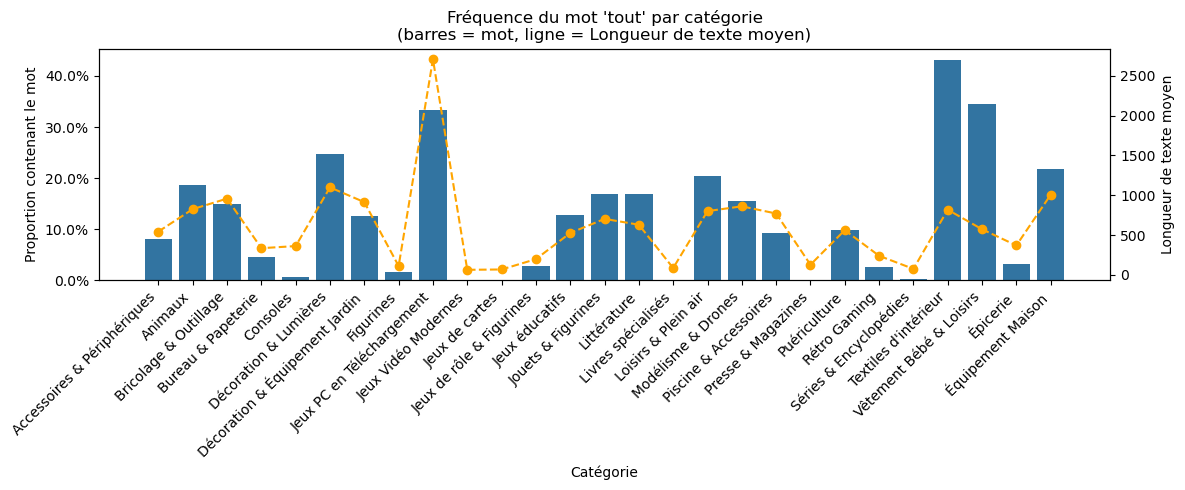

In [50]:
from matplotlib.ticker import PercentFormatter
import re

text_col = 'text'
keyword = "tout"
pattern = fr"\b{re.escape(keyword)}\b"
contains_word = df[text_col].str.contains(pattern, na=False)
len_text = df[text_col].apply(len)
agg = df.assign(contains_word=contains_word, len_text=len_text).groupby("category").agg(
    contains_ratio=("contains_word", "mean"),
    mean_len_text=("len_text", "mean"),
).reset_index()
agg
fig, ax1 = plt.subplots(figsize=(12, 5))
plt.xticks(rotation=45, ha="right")
sns.barplot(data=agg, x="category", y="contains_ratio", ax=ax1)
ax1.set_ylabel("Proportion contenant le mot")
ax1.yaxis.set_major_formatter(PercentFormatter(1.0))
ax2 = ax1.twinx()
ax2.plot(ax1.get_xticks(), agg["mean_len_text"], marker="o", linestyle="--", color='orange')
ax2.set_ylabel("Longueur de texte moyen")
ax1.set_xlabel("Catégorie")
plt.title(f"Fréquence du mot '{keyword}' par catégorie\n"
          f"(barres = mot, ligne = Longueur de texte moyen)")

fig.tight_layout()
plt.show()

<div style="background:#f0f8ff; padding:12px; border-radius:6px">Le taux d’apparition du mot "tout" par catégorie semble corrélé à la longueur moyenne des descriptions : les catégories avec des textes plus longs affichent également un taux plus élevé de ce mot.

Par exemple, Textiles d’intérieur et Jeux PC en Téléchargmenet présentent une proportion notable de “tout”. Pour la catégorie, Jeux Pc, les descriptions sont longuent car elles décrivent l'histoire qui se cache derrière le jeu video. 
Pour quantifier cette relation, nous calculons le coefficient de corrélation de Pearson entre le taux d’apparition du mot et la longueur moyenne des textes par catégorie :

<div style="background:#f0f8ff; padding:12px; border-radius:6px">
    
### 5.4 Relation entre la longueur des textes et les mots génériques



In [53]:
import scipy.stats as stats

pearson_coeff, p_value = stats.pearsonr(agg['contains_ratio'], agg['mean_len_text'])

print(f"P value : {p_value:.4f}")
print(f"coefficient de corrélation : {pearson_coeff:.2f}")

P value : 0.0000
coefficient de corrélation : 0.71


<div style="background:#f0f8ff; padding:12px; border-radius:6px">Ce score élevé montre qu’il existe une corrélation assez forte : le mot “tout” n’apporte donc pas beaucoup d’information supplémentaire pour distinguer les catégories. Nous pouvons envisager de l’ajouter à notre liste de stop words.


Enfin, nous notons que certains commentaires sont rédigés dans des langues étrangères. La prochaine étape consiste à les détecter et les taguer à l’aide de la librairie langdetect, préparant ainsi les textes pour les analyses suivantes.

<div style="background:#f0f8ff; padding:12px; border-radius:6px">
    
### 5.5 Détection de la langue des descriptions



<div style="background:#f0f8ff; padding:12px; border-radius:6px">Enfin, nous détectons la langue des descriptions pour garantir la cohérence linguistique des textes.  Cela permet de vérifier que la majorité des textes sont en français et d’identifier d’éventuelles entrées en langues étrangères, qui pourraient fausser l’analyse thématique et la labellisation des catégories.

In [57]:
!pip install langdetect

In [58]:
from langdetect import detect, DetectorFactory

# Fixe la graine pour des résultats reproductibles
DetectorFactory.seed = 0

# Fonction de détection
def detect_lang(text):
    try:
        return detect(text)
    except:
        return "unknown"

df["detected_lang"] = df["text"].apply(detect_lang)

<div style="background:#f0f8ff; padding:12px; border-radius:6px">Ensuite, nous calculons le taux de textes en français par groupe et catégorie, en excluant les textes dont la langue n’a pas pu être détectée :

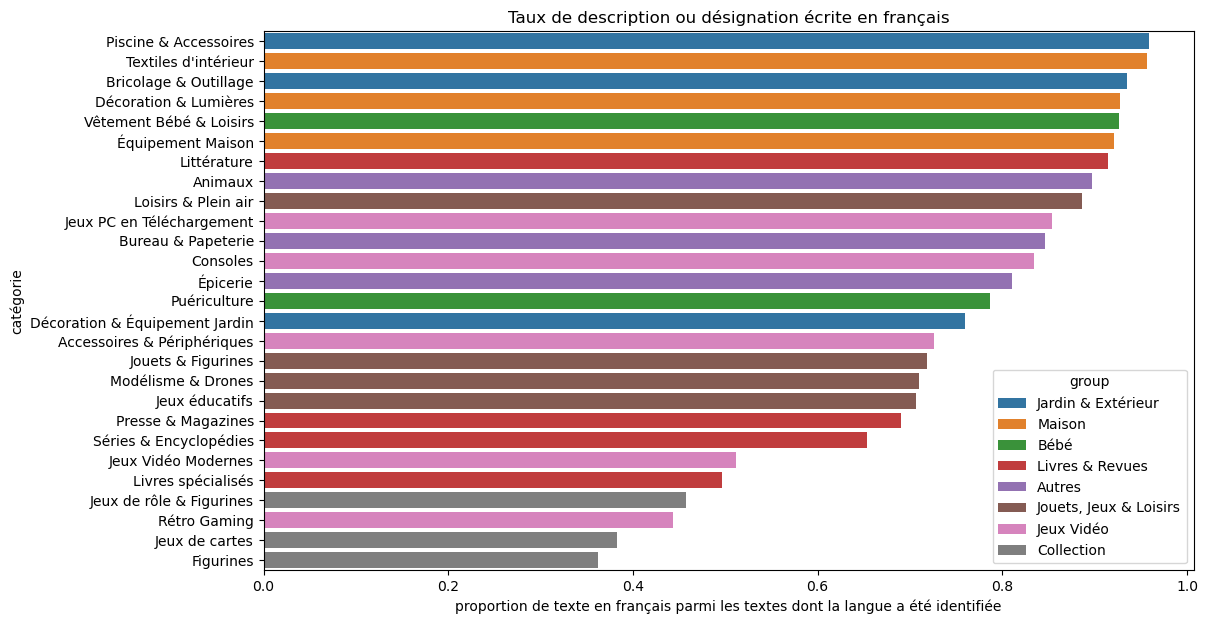

In [60]:
fr_rate = df[df["detected_lang"] == 'fr'][['group', 'category']].value_counts() / df[df["detected_lang"] != 'unknown'][['group', 'category']].value_counts()
fr_rate = fr_rate.sort_values(ascending=False).reset_index()
plt.figure(figsize=(12,7))
sns.barplot(data=fr_rate, x='count', y='category', hue='group')
plt.title("Taux de description ou désignation écrite en français")
plt.ylabel('catégorie')
plt.xlabel('proportion de texte en français parmi les textes dont la langue a été identifiée');

<div style="background:#f0f8ff; padding:12px; border-radius:6px">Enfin, pour mieux visualiser les langues étrangères, nous créons un tableau croisé par langue et groupe, et regroupons les langues peu représentées sous la catégorie “autre” :

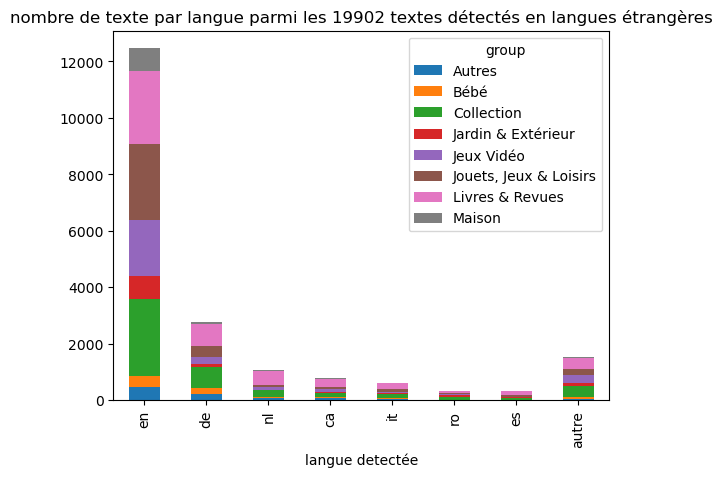

In [62]:
mask = (df["detected_lang"] != 'fr') & (df["detected_lang"] != 'unknown')
ct = pd.crosstab(df[mask]["detected_lang"], df[mask]["group"])
ct = ct.loc[ct.sum(axis=1).sort_values(ascending=False).index]
# pour faire une catégorie "autre" et simplifier le graphique
th = 300
other = ct[ct.sum(axis=1) <= th]
ct = ct.drop(other.index)
ct.loc['autre',:] = other.sum()

ct.plot(kind='bar', stacked=True);
plt.title(f"nombre de texte par langue parmi les {mask.sum()} textes détectés en langues étrangères")
plt.xlabel('langue detectée');

<div style="background:#f0f8ff; padding:12px; border-radius:6px">L’analyse révèle que, parmi les textes identifiés comme non francophones, une large majorité est rédigée en anglais. En effet, plus de 12 000 textes ont été détectés en anglais parmi les 19 902 descriptions en langue étrangère, ce qui en fait de loin la langue la plus représentée dans cette catégorie. Ce résultat est cohérent avec la structure habituelle des marketplaces ou catalogues produits, où l’anglais constitue souvent la langue par défaut pour les descriptions génériques ou importées.

Derrière l’anglais, on observe également une présence non négligeable du néerlandais de l’allemand et du néerlandais, bien que dans des proportions nettement inférieures. Ces deux langues apparaissent principalement dans certains groupes de produits comme Livres & Revues.

# VI - Extraction des Features : informations chiffrées et technicité des descriptions

<div style="background:#f0f8ff; padding:12px; border-radius:6px"> Après avoir finalisé la labellisation des catégories et vérifié la cohérence linguistique des descriptions (notamment grâce à la détection des langues), nous nous intéressons maintenant aux features des textes.
Ces features, comme la présence de chiffres, de tailles ou d’unités, constituent le premier pas concret pour préparer les données en vue d’entraîner nos modèles.
L’objectif est d’évaluer le niveau de technicité de chaque catégorie et de déterminer si les produits sont principalement décrits par des phrases ou par des valeurs chiffrées, ce qui permettra d’identifier des features discriminantes, ce qui orientera ensuite la construction de nos modèles prédictifs.

<div style="background:#f0f8ff; padding:12px; border-radius:6px">
    
### 6.1 Analyse de la présence de chiffres par catégorie

<div style="background:#f0f8ff; padding:12px; border-radius:6px">Pour comprendre la technicité des descriptions produits et le type d’informations qu’elles contiennent, nous avons d’abord exploré le dataframe pour vérifier les colonnes disponibles et leur contenu

In [68]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 84478 entries, 0 to 84915
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               84478 non-null  int64 
 1   designation              84478 non-null  object
 2   description              54731 non-null  object
 3   productid                84478 non-null  int64 
 4   imageid                  84478 non-null  int64 
 5   text                     84478 non-null  object
 6   text_cleaned             84478 non-null  object
 7   designation_cleaned      84475 non-null  object
 8   description_cleaned      54595 non-null  object
 9   prdtypecode              84478 non-null  int64 
 10  image_path               84478 non-null  object
 11  hashed_image             84478 non-null  object
 12  is_duplicated_full       84478 non-null  bool  
 13  category                 84478 non-null  object
 14  group                    84478 non-null  ob

<div style="background:#f0f8ff; padding:12px; border-radius:6px">Ensuite, nous avons créé une nouvelle colonne text_cleaned en combinant designation_cleaned et description_cleaned de chaque produit. Cela nous permet de travailler sur l’intégralité du texte associé à chaque produit plutôt que sur les colonnes séparées, facilitant ainsi l’extraction de nouvelles features.

In [70]:
df[["designation_cleaned", "description_cleaned", "text_cleaned"]].head()


designation_cleaned  \
0  olivia: personalisiertes notizbuch 150 seiten ...   
1  journal arts (le) n° 133 28/09/2001 l'art marc...   
2  stylet ergonomique bleu gamepad nintendo wii s...   
3  peluche donald europe disneyland 2000 (marionn...   
4                                      guerre tuques   

                                 description_cleaned  \
0                                                NaN   
1                                                NaN   
2  pilot style touch pen marque speedlink stylet ...   
3                                                NaN   
4  luc idées grandeur veut organiser jeu guerre b...   

                                        text_cleaned  
0  olivia: personalisiertes notizbuch 150 seiten ...  
1  journal arts (le) n° 133 28/09/2001 l'art marc...  
2  stylet ergonomique bleu gamepad nintendo wii s...  
3  peluche donald europe disneyland 2000 (marionn...  
4  guerre tuques luc idées grandeur veut organise...

<div style="background:#f0f8ff; padding:12px; border-radius:6px">Pour quantifier le niveau de technicité, nous avons défini une fonction count_digits qui compte le nombre de chiffres dans un texte. Cette feature permet d’identifier les catégories où les descriptions contiennent beaucoup de mesures, références ou tailles, par opposition à des textes plutôt descriptifs ou narratifs.

In [72]:
def count_digits(text):
    """
    Compte le nombre de chiffres (0-9) dans une chaîne de caractères.
    """

    compteur = 0
    for caractere in text:
        if caractere.isdigit():
            compteur = compteur + 1
    return compteur

df["nb_digits_text"] = df["text_cleaned"].apply(count_digits)

df[["text_cleaned", "nb_digits_text"]].head(10)


text_cleaned  nb_digits_text
0  olivia: personalisiertes notizbuch 150 seiten ...               4
1  journal arts (le) n° 133 28/09/2001 l'art marc...              11
2  stylet ergonomique bleu gamepad nintendo wii s...               4
3  peluche donald europe disneyland 2000 (marionn...               4
4  guerre tuques luc idées grandeur veut organise...               0
5  afrique contemporaine n° 212 hiver 2004 dossie...               7
6         christof e: bildungsprozessen auf der spur               0
7  conquérant sept cahier couverture polypro 240x...              30
8               puzzle scooby-doo poster 2x35 pieces               3
9  tente pliante v3s5-pro pvc blanc 4m50 longueur...              72

<div style="background:#f0f8ff; padding:12px; border-radius:6px">
Nous avons ensuite calculé pour chaque catégorie la moyenne, la médiane, le minimum et le maximum du nombre de chiffres par texte. 

In [74]:
target_col = "category"

liste_categories = df[target_col].unique()

resultats = []

for cat in sorted(liste_categories):
    sous_df = df[df[target_col] == cat]
    moyenne = sous_df["nb_digits_text"].mean()
    mediane = sous_df["nb_digits_text"].median()
    minimum = sous_df["nb_digits_text"].min()
    maximum = sous_df["nb_digits_text"].max()

    resultats.append({
        "category": cat,
        "mean_nb_digits": moyenne,
        "median_nb_digits": mediane,
        "min_nb_digits": minimum,
        "max_nb_digits": maximum
    })

stats_digits = pd.DataFrame(resultats)

stats_digits = stats_digits.sort_values("mean_nb_digits", ascending=False)

stats_digits.head(15)


category  mean_nb_digits  median_nb_digits  \
8        Jeux PC en Téléchargement       41.490826              31.0   
17              Modélisme & Drones       32.658240              19.0   
18           Piscine & Accessoires       31.713840              15.0   
2            Bricolage & Outillage       28.933279              18.0   
1                          Animaux       23.749696              13.0   
6   Décoration & Équipement Jardin       19.891817              15.0   
5            Décoration & Lumières       19.442084              13.0   
26               Équipement Maison       18.699783              14.0   
23            Textiles d'intérieur       14.821395              12.0   
16             Loisirs & Plein air       14.197098               9.0   
13              Jouets & Figurines       14.121430               7.0   
24         Vêtement Bébé & Loisirs       13.368821               8.0   
20                    Puériculture       12.793082               6.0   
3               Bureau & Papeterie       10.971687               9.0   
0      Accessoires & Périphériques       10.640215               3.0   

    min_nb_digits  max_nb_digits  
8               0            245  
17              0            800  
18              0            522  
2               0           3288  
1               0            727  
6               0            182  
5               0           1181  
26              0            349  
23              0            177  
16              0            167  
13              0            479  
24              0            164  
20              0            193  
3               0            186  
0               0            416

<div style="background:#f0f8ff; padding:12px; border-radius:6px">Nous constatons que les moyennes sont très différentes selon les catégories (41,49 pour les Jeux PC en téléchargement contre 10,9 pour la catégorie Bureau & Papeterie), ce qui confirme que la feature nb_digits_text est effectivement discriminante. La catégorie Jeux Pc a souvent des numéros ou encore des unités car les caractéristiques de l'équipement nécessaires au programme sont également listés. 

<div style="background:#f0f8ff; padding:12px; border-radius:6px">Le graphique ci-dessous met en évidence les catégories présentant les moyennes de chiffres les plus élevées, offrant un premier aperçu des catégories les plus "techniques". On observe que certaines familles de produits, notamment celles liées au Jeux PC, au Modélisme ou aux équipements de piscine comportent naturellement de nombreuses valeurs chiffrées : dimensions, références produit, tailles de fichiers, versions ou caractéristiques techniques.

À l’inverse, les catégories affichant les moyennes les plus faibles correspondent à des univers beaucoup plus littéraires, comme Livres spécialisés ou Littérature, où les descriptions reposent essentiellement sur du texte continu, sans éléments numériques

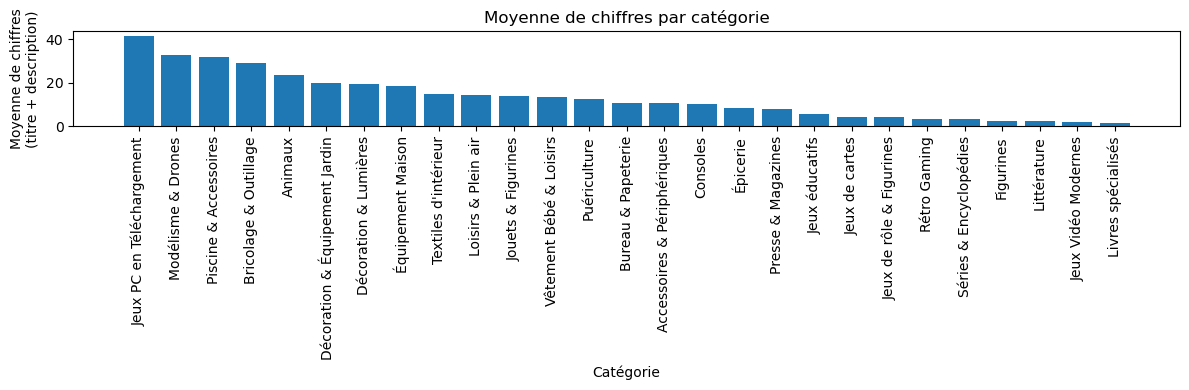

In [77]:
plt.figure(figsize=(12, 4))

plt.bar(
    stats_digits["category"].astype(str),
    stats_digits["mean_nb_digits"]
)

plt.xlabel("Catégorie")
plt.ylabel("Moyenne de chiffres\n(titre + description)")
plt.title("Moyenne de chiffres par catégorie")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


<div style="background:#f0f8ff; padding:12px; border-radius:6px">
    
### 6.2 Détection d'unités par catégorie




<div style="background:#f0f8ff; padding:12px; border-radius:6px">Après avoir étudié la quantité de chiffres présents dans les descriptions, nous approfondissons désormais la question de la technicité en détectant la présence d’unités de mesure (cm, kg, pouces, mois, etc.).
Ces unités constituent des marqueurs forts de descriptions techniques : elles traduisent des dimensions, du poids, des volumes, des références produit ou encore des indications d’âge. Leur présence permet donc de distinguer les catégories dans lesquelles les produits nécessitent des spécifications précises de celles où les descriptions sont plus narratives ou éditoriales.

<div style="background:#f0f8ff; padding:12px; border-radius:6px">Nous avons construit un ensemble de motifs (regex) capables de capter différents types d’unités — dimensions, poids, volume, âge, mesures techniques, puis nous avons créé une variable binaire indiquant si chaque description contient au moins une unité, ce qui nous permet après de calculer catégorie par catégori, le pourcentage de descriptions comportant une unité.

In [97]:
import re

unit_patterns = {
    # Dimensions
    "cm":   r"\b\d+\s*(cm|centimetre?s?|centimètre?s?)\b",
    "mm":   r"\b\d+\s*(mm|millimetre?s?|millimètre?s?)\b",
    "m":    r"\b\d+\s*(m|metre?s?|mètre?s?)\b",

    # Poids
    "kg":   r"\b\d+\s*(kg|kilo|kilogramme?s?)\b",
    "g":    r"\b\d+\s*(g|gramme?s?)\b",

    # Volume
    "ml":   r"\b\d+\s*(ml|millilitres?|millilitre?)\b",
    "l":    r"\b\d+\s*(l|litres?|litre?)\b",
    "cl":   r"\b\d+\s*cl\b",  

    # Dimensions suivies d'une unité
    "x_dim": r"\b\d+\s*(x|×)\s*\d+(\s*(cm|mm|m))?\b",

    # Âge
    "age_ans":  r"\b\d+\s*ans\b",
    "age_mois": r"\b\d+\s*mois\b",

    # Tranches d'âge: 
    "age_range_ans":  r"\b\d+\s*[-–/]\s*\d+\s*ans\b",
    "age_range_mois": r"\b\d+\s*[-–/]\s*\d+\s*mois\b",

    # Age minimum 
    "age_min_ans": r"\b(?:à\s*partir\s*de\s*)?\d+\s*ans\s*(?:et\s*plus|\+|plus)?\b",

    # Pointure 
    "pointure": r"\bpointures?\s*:?(\s*(eu|eur|fr))?\s*"
                r"\d{2}(?:[.,]\d)?(\s*[-/]\s*\d{2}(?:[.,]\d)?)?\b",

    # Pouces (écrans)
    "inch": r'\b\d+\s*(\"|pouces?|po)\b',

    # Temps 
    "time_heures": r"\b\d+\s*(?:h|heures?)\b",       
    "time_jours":  r"\b\d+\s*jours?\b",             

    # Stockage / mémoire
    "go":   r"\b\d+\s*(go|giga-?octets?)\b",        
    "gb":   r"\b\d+\s*(gb|gigabytes?)\b",          
    "mo":   r"\b\d+\s*(mo|méga-?octets?|mega-?octets?)\b", 
    "mb":   r"\b\d+\s*(mb|megabytes?)\b",         
    "ko":   r"\b\d+\s*(ko|kilo-?octets?)\b",      
    "kb":   r"\b\d+\s*(kb|kilobytes?)\b",

    # RAM / VRAM3
    "ram":  r"\b\d+\s*(go|gb|mo|mb)\s*ram\b",      
    "vram": r"\b\d+\s*(go|gb|mo|mb)\s*vram\b",      

    # Fréquence CPU / GPU
    "ghz":  r"\b\d+(?:\.\d+)?\s*ghz\b",           
    "mhz":  r"\b\d+(?:\.\d+)?\s*mhz\b",

    # Architecture (32-bit / 64-bit)
    "bits": r"\b(32|64)\s*[- ]?(?:bit|bits)\b",     

    # Débit réseau
    "kbps": r"\b\d+\s*kbps\b",                     
    "mbps": r"\b\d+\s*mbps\b",

    # Framerate
    "fps":  r"\b\d+\s*fps\b",                       
}

compiled_patterns = []
for pattern in unit_patterns.values():
    regex_obj = re.compile(pattern, flags=re.IGNORECASE)
    compiled_patterns.append(regex_obj)

In [99]:
def detect_any_unit(text, list_of_regex):
    """
    Retourne 1 si le texte contient au moins une unité (parmi la liste de regex),
    sinon 0.
    """
    text = str(text)

    for regex_pattern in list_of_regex:
        if regex_pattern.search(text):
            return 1
    return 0

In [101]:
df["has_any_unit"] = df["text_cleaned"].apply(
    lambda txt: detect_any_unit(txt, compiled_patterns)
)

df[["text_cleaned", "has_any_unit"]].head(10)

text_cleaned  has_any_unit
0  olivia: personalisiertes notizbuch 150 seiten ...             0
1  journal arts (le) n° 133 28/09/2001 l'art marc...             1
2  stylet ergonomique bleu gamepad nintendo wii s...             0
3  peluche donald europe disneyland 2000 (marionn...             0
4  guerre tuques luc idées grandeur veut organise...             0
5  afrique contemporaine n° 212 hiver 2004 dossie...             0
6         christof e: bildungsprozessen auf der spur             0
7  conquérant sept cahier couverture polypro 240x...             1
8               puzzle scooby-doo poster 2x35 pieces             1
9  tente pliante v3s5-pro pvc blanc 4m50 longueur...             1

In [103]:
target_col = "category"

liste_categories = sorted(df[target_col].unique())

resultats = []

for cat in liste_categories:
    sous_df = df[df[target_col] == cat]

    nb_produits = len(sous_df)
    if nb_produits == 0:
        continue

    taux_unites = sous_df["has_any_unit"].mean()
    pourcentage = taux_unites * 100

    resultats.append({
        "categorie": cat,
        "nb_products": nb_produits,
        "pct_products_with_unit": pourcentage
    })

stats_units_any = pd.DataFrame(resultats)

# Affichage des catégories par pourcentage décroissant
stats_units_any = stats_units_any.sort_values(
    "pct_products_with_unit",
    ascending=False
)

stats_units_any.head(20)

categorie  nb_products  pct_products_with_unit
23            Textiles d'intérieur         4300               89.209302
26               Équipement Maison         5063               80.387122
5            Décoration & Lumières         4990               79.819639
1                          Animaux          823               79.343864
6   Décoration & Équipement Jardin         2542               75.963808
8        Jeux PC en Téléchargement          872               72.133028
24         Vêtement Bébé & Loisirs          789               71.609632
2            Bricolage & Outillage         2473               69.712899
18           Piscine & Accessoires         9935               65.968797
3               Bureau & Papeterie         4980               65.000000
16             Loisirs & Plein air         2481               63.966143
25                        Épicerie          802               58.603491
20                    Puériculture         3238               50.957381
17              Modélisme & Drones         5024               50.318471
13              Jouets & Figurines         4867               49.517156
4                         Consoles          829               49.215923
12                  Jeux éducatifs         2069               31.657806
0      Accessoires & Périphériques         1676               28.341289
7                        Figurines         2671               25.683265
11        Jeux de rôle & Figurines          763               13.761468

<div style="background:#f0f8ff; padding:12px; border-radius:6px"> Les résultats montrent des écarts très marqués entre les catégories:
    <div style="background:#f0f8ff; padding:12px; border-radius:6px">
         -  Certaines catégories dépassent les 80 % de produits contenant au moins une unité, révélant un très haut niveau de technicité. Cela concerne notamment les catégories liées aux équipements, au bricolage, au modélisme ou à la maison, où les produits nécessitent de nombreuses spécifications : dimensions, poids, volumes, références techniques, etc.
         <div style="background:#f0f8ff; padding:12px; border-radius:6px">
         -  À l’inverse, d’autres catégories présentent des taux très faibles, proches de 10 % ou quelques pourcents seulement. C’est notamment le cas des catégories éditoriales, littéraires, jeux , où les descriptions reposent majoritairement sur du texte narratif sans valeurs chiffrées.

<div style="background:#f0f8ff; padding:12px; border-radius:6px">Nous visualisons ensuite, à l’aide d’un graphique en barres horizontales, le pourcentage de produits contenant au moins une unité pour chaque catégorie.Ce graphique permet de comparer directement les catégories entre elles et de repérer immédiatement lesquelles reposent le plus sur des mesures chiffrées.

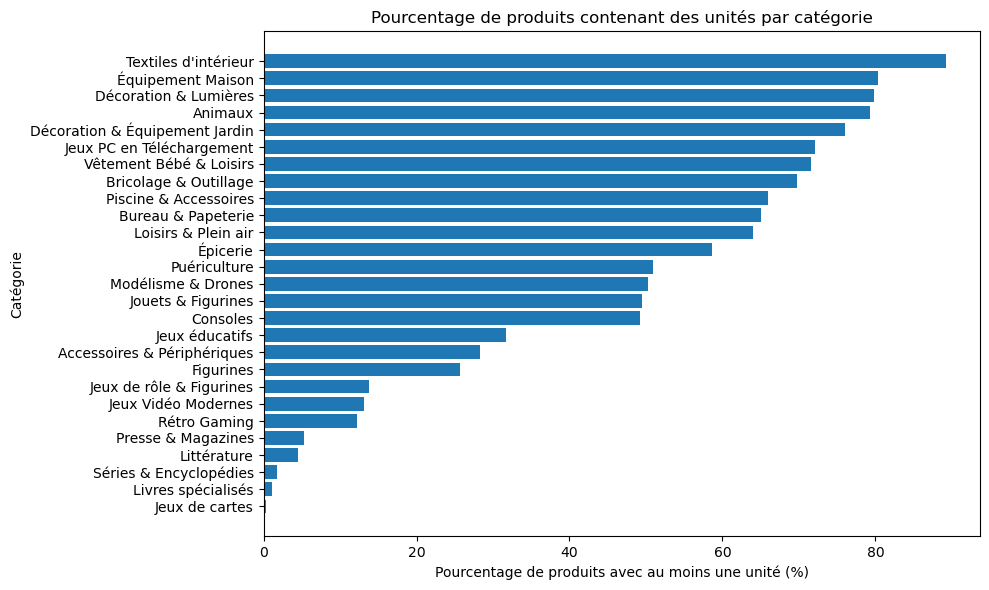

In [105]:
plt.figure(figsize=(10, 6))


plot_df = stats_units_any.sort_values("pct_products_with_unit", ascending=True)

plt.barh(
    plot_df["categorie"].astype(str),
    plot_df["pct_products_with_unit"]
)

plt.xlabel("Pourcentage de produits avec au moins une unité (%)")
plt.ylabel("Catégorie")
plt.title("Pourcentage de produits contenant des unités par catégorie")
plt.tight_layout()
plt.show()


<div style="background:#f0f8ff; padding:12px; border-radius:6px">Les résultats montrent des contrastes très nets :

En haut du classement se trouvent les catégories dont plus de 70 % des descriptions contiennent au moins une unité (cm, kg, L, pouces, mois…).
Il s’agit principalement de catégories techniques comme textiles, bricolage, décoration, équipement de la maison où les produits exigent des spécifications détaillées (dimensions, poids, volumes, références techniques), comme la catégorie Animaux.
En bas du graphique, certaines catégories affichent des taux extrêmement faibles, parfois inférieurs à 5 %.
Ces catégories sont essentiellement éditoriales, littéraires ou ludiques (Livres spécialisés, Littérature, Jeux de Cartes), où les descriptions s'appuient surtout sur du texte et très peu sur des valeurs numériques.

<div style="background:#f0f8ff; padding:12px; border-radius:6px">Dans un second temps, nous croisons ce pourcentage avec le nombre moyen de chiffres par description. Le scatterplot final met en évidence quatre groupes distincts :
    
 - En haut à droite : les catégories les plus techniques, cumulant beaucoup de chiffres et un pourcentage élevé d’unités.
 - En bas à gauche : les catégories les plus textuelles, où les descriptions sont littéraires ou informatives, avec très peu de mesures.
 - Entre les deux : un gradient continu de technicité intermédiaire.

Ce double indicateur (chiffres + unités) confirme ainsi sa pertinence comme feature discriminante, particulièrement utile pour la suite du travail de modélisation.




In [107]:
target_col = "category"

liste_categories = sorted(df[target_col].unique())

resultats_cat = []

for cat in liste_categories:
    sous_df = df[df[target_col] == cat]

    nb_produits = len(sous_df)
    if nb_produits == 0:
        continue

    mean_nb_digits = sous_df["nb_digits_text"].mean()


    taux_unites = sous_df["has_any_unit"].mean()
    pct_with_unit = taux_unites * 100

    resultats_cat.append({
        "category": cat,
        "nb_products": nb_produits,
        "mean_nb_digits": mean_nb_digits,
        "pct_with_unit": pct_with_unit
    })

stats_cat = pd.DataFrame(resultats_cat)

stats_cat.head()


category  nb_products  mean_nb_digits  pct_with_unit
0  Accessoires & Périphériques         1676       10.640215      28.341289
1                      Animaux          823       23.749696      79.343864
2        Bricolage & Outillage         2473       28.933279      69.712899
3           Bureau & Papeterie         4980       10.971687      65.000000
4                     Consoles          829       10.293124      49.215923

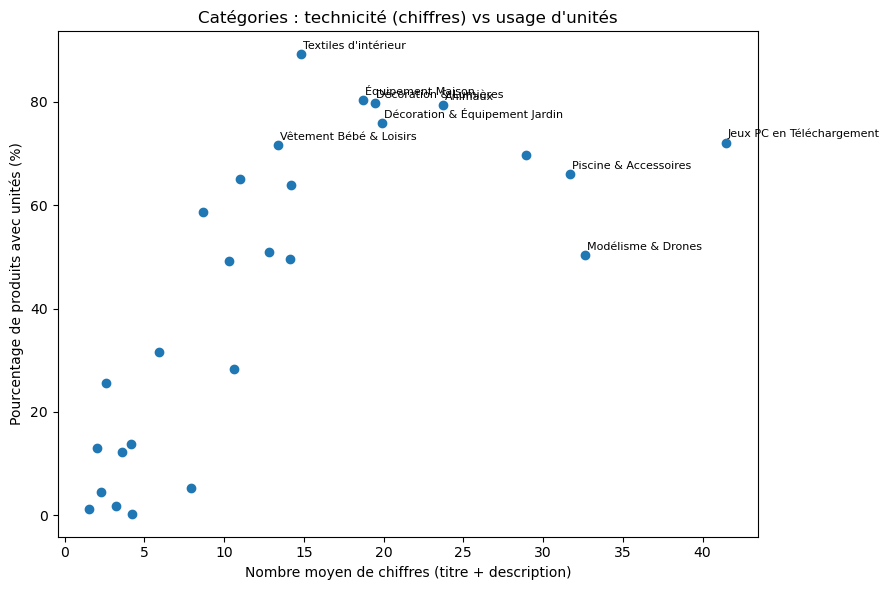

In [109]:
plt.figure(figsize=(9, 6))

plt.scatter(
    stats_cat["mean_nb_digits"],
    stats_cat["pct_with_unit"]
)

plt.xlabel("Nombre moyen de chiffres (titre + description)")
plt.ylabel("Pourcentage de produits avec unités (%)")
plt.title("Catégories : technicité (chiffres) vs usage d'unités")

seuil_pct = 70
seuil_digits = stats_cat["mean_nb_digits"].quantile(0.9)

for _, row in stats_cat.iterrows():
    x = row["mean_nb_digits"]
    y = row["pct_with_unit"]
    nom_cat = str(row["category"])

    if (y > seuil_pct) or (x > seuil_digits):
        plt.text(x + 0.1, y + 1, nom_cat, fontsize=8)

plt.tight_layout()
plt.show()



<div style="background:#f0f8ff; padding:12px; border-radius:6px">En croisant le nombre de chiffres avec l’usage d’unités, le nuage de points révèle clairement deux mondes.
D’un côté, les catégories “techniques”; celles où l’on ressent presque le besoin d’un mètre et d’une calculette pour suivre la description. Les piscines, le modélisme ou encore l’équipement du jardin s’y distinguent nettement : beaucoup de mesures, beaucoup d’unités, et une communication produit qui repose avant tout sur la précision.
À l’opposé, les univers plus ludiques; jeux, figurines, produits culturels se reconnaissent immédiatement : peu de chiffres, presque aucune unité, et des textes centrés sur l’expérience plutôt que sur les spécifications.
Ainsi, le graphique ne raconte pas seulement une distribution statistique : il dessine la frontière naturelle entre les catégories “de mesure” et les catégories “d’imaginaire”.

<div style="background:#f0f8ff; padding:12px; border-radius:6px">
    
### 6.3 Présence de numéro dans la description produit


<div style="background:#f0f8ff; padding:12px; border-radius:6px"> Nous allons détecter les mentions de type "n°4838" dans les descriptions produit afin d'identifier les catégories où la notion de numéro est fréquente.

Les mentions numérotées sont souvent utilisées pour identifier un volume, un numéro d’édition ou un élément de collection. Nous allons créer la variable contains_numerotation pour isoler ce motif dans le texte nettoyé.



/var/folders/4n/cbddqh2d0lvdqjjrxgt2jb500000gn/T/ipykernel_99568/259270256.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df["contains_numerotation"] = df["text_cleaned"].str.contains(r"n° ?([0-9])+")


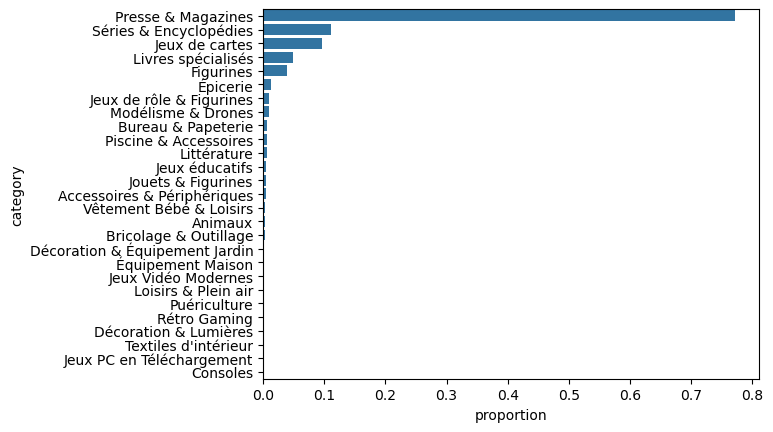

In [112]:
df["contains_numerotation"] = df["text_cleaned"].str.contains(r"n° ?([0-9])+")
num_counts = (df[df["contains_numerotation"]]["category"].value_counts() / df["category"].value_counts()).fillna(0).sort_values(ascending=False)
sns.barplot(num_counts, orient='h')
plt.xlabel('proportion');

<div style="background:#f0f8ff; padding:12px; border-radius:6px">Nous constatons que certains produits possèdent des numéros de parution, cela concerne plus de 80% de la catégorie "Presse&Magazine".

Résultat: la feature contains_numerotation est très spécifique des produits de type presse et est donc discriminant donc pertinent à prendre en compte.

En conclusion, les features dérivées des chiffres, des unités et des mentions d’âge / taille / pointure apportent une distinction forte, elles permettent de mieux séparer les familles de produits et de comprendre ce que le modèle pourra exploiter au-delà de TF-IDF.

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

### 6.4 Tester l'impact de variables indicatrices sur la présence ou non de certains mots

<div style="background:#f0f8ff; padding:12px; border-radius:6px">L’objectif de cette section est de transformer notre texte brut en variables réellement exploitables pour un futur modèle de classification. Avant de construire ces features, nous avons commencé par une exploration qualitative grâce aux nuages de mots générés précédemment. Cette étape visuelle nous a permis d’identifier les termes les plus fréquents dans chaque catégorie,les expressions qui structurent naturellement les descriptions, et surtout, les mots potentiellement discriminants.
Cette première lecture a rapidement révélé des signaux forts : par exemple, « collier » et « chien » dominaient nettement dans la catégorie Animaux, alors que des termes comme « coussin » et « taie » apparaissaient systématiquement dans Textiles d’intérieur.
À partir de ces observations, nous construisons ici un dictionnaire de mots-clés par catégorie. Ces listes serviront de base à la création d'une variable indicatrice, permettant de tester l’impact de la présence de ces mots sur la classification automatique des produits.

In [ ]:
import pandas as pd
import numpy as np

# 1. Definir les mots clés par catégorie

keyword_dict = {
    "Animaux": [ "chien", "chat", "animal", "compagnie", "collier"],
    "Bureau & Papeterie": ["verso", "cahier", "encre", "papier", "recto", "a5"],
    "Épicerie": ["epices", "arôme", "chocolat", "sucre", "sachet", "capsule"],
    "Puériculture": ["langer", "bavoir", "assiette", "siege", "tétine", "poussette"],
    "Vêtement Bébé & Loisirs": ["bébé", "chaussettes", "paire", "longueur", "filles","garçons"],
    "Figurines": ["figurine", "gundam", "statuette", "officiel", "marvel", "funko"],
    "Jeux de cartes":["mtg", "oh", "rare", "vf", "carte", "magic"],
    "Jeux de rôle & Figurines": ["halloween", "figurine", "warhammer", "prince", "masque"],
    "Bricolage & Outillage": ["arrosage", "tondeuse", "aspirateur", "appareils", "outil", "coupe", "bâche"],
    "Décoration & Équipement Jardin": ["bois", "jardin", "résistant", "tente", "parasol", "aluminium"],
    "Piscine & Accessoires": ["piscine", "filtration", "pompe", "dimensions","eau", "ronde"],
    "Accessoires & Périphériques":["nintendo", "manette", "protection", "ps4", "silicone", "câble"],
    "Consoles": ["console", "oui", "jeu", "écran", "portable", "marque", "jeux"],
    "Jeux PC en Téléchargement":["windows", "jeu", "directx", "plus", "téléchargement", "disque", "édition"],
    "Jeux Vidéo Modernes": ["duty","jeux", "manettes", "ps3", "xbox", "kinect"],
    "Rétro Gaming": ["japonais", "import", "langue", "titres", "sous", "français"],
    "Jeux éducatifs": ["joue", "cartes", "enfants", "éducatif", "bois", "jouer"],
    "Jouets & Figurines": ["doudou", "enfants", "cadeau", "peluche", "jouet", "puzzle"],
    "Loisirs & Plein air": ["camping", "pêche", "stress", "stream", "bracelet", "trampoline"],
    "Modélisme & Drones": ["drone", "générique", "dji", "avion", "batterie", "cámera", "one"],
    "Littérature": ["monde", "ouvrage", "siècle", "roman", "livre", "histoire", "tome"],
    "Livres spécialisés": ["guide", "édition", "histoire", "art", "collection"],
    "Presse & Magazines": ["journal", "france", "illustre", "magazine", "presse", "revue"],
    "Séries & Encyclopédies":[ "lot", "livres", "tomes", "volumes", "tome", "revues"],
    "Décoration & Lumières": ["led", "noël", "lumière", "lampe", "décoration", "couleur"],
    "Textiles d'intérieur": ["oreiller", "taie", "coussin", "couverture", "canapé", "cotton"],
     "Équipement Maison":["matelas", "assise", "bois", "table", "hauteur", "mousse"]

}

# Construire un texte global
df["text"] = (df["designation_cleaned"].fillna("") + " " +df["description_cleaned"].fillna("")).str.lower()

# Génération des colonnes de comptage

data = {}

for cat, mots in keyword_dict.items():
    pattern = '|'.join(mots)  # expression régulière
    data[cat + "_keywords"] = df["text"].str.count(pattern)

# Convertir en DataFrame final
new_X = pd.DataFrame(data)
new_X

<div style="background:#f0f8ff; padding:12px; border-radius:6px"> On observe le nombre exact d’occurrences des mots-clés associés à chaque catégorie de keywords. Si plusieurs mots-clés d’une même catégorie apparaissent plusieurs fois, chaque apparition est comptabilisée et reflétée dans la cellule correspondante.

<div style="background:#f0f8ff; padding:12px; border-radius:6px"> Après avoir construit notre dictionnaire final de mots-clés, nous voulons vérifier comment ces mots se distribuent dans l’ensemble des produits.

In [ ]:
# keywords / catégorie
total_keywords_per_category = new_X.sum().sort_values(ascending = False)
total_keywords_per_category



<div style="background:#f0f8ff; padding:12px; border-radius:6px">En regardant le total des occurrences par catégorie, on voit que les mots-clés de « Piscine & Accessoires » domine largement (122 994 occurrences), suivi par « Décoration & Lumières » (70 198) et « Équipement Maison » (54 971). Cela indique que les termes de ces catégories sont très fréquents dans les textes. À l’inverse, lest mots des catégories comme « Puériculture » (2 639) ou « Épicerie » (2 446) apparaissent beaucoup moins.

<div style="background:#f0f8ff; padding:12px; border-radius:6px">Une fois quelques mots-clés potentiels repérés, nous avons voulu vérifier s’ils étaient réellement représentatifs de la catégorie officielle. Pour cela, nous utilisons le texte combiné (désignation + description) et nous calculons, pour un mot donné, la proportion de produits dans chaque catégorie qui le contiennent.

L’objectif est simple : si un mot provient bien de la bonne catégorie, alors sa fréquence doit être nettement plus élevée dans cette catégorie que dans les autres.

Ce test visuel (barplot) nous permet de analyser la fréquence d’un mot dans chaque catégorie. Si les mots sont:réellement discriminants (on les garde),trop génériques (on les élimine) ou s’il apparaît dans plusieurs catégories,(il peut être ambigu). Dans ce cas : nous observons le pourcentage total de produits contenant ce mot, nous comparons sa distribution entre catégories, et nous décidons si le mot doit être reclassé, conservé ou supprimé.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
y = df['category']
for keyword in ["oreiller", "taie", "coussin"]:
    count_kw = df["text"].str.lower().str.count(keyword)
    cat_counts = y.value_counts()
    freq = {}
    for cat, count in cat_counts.items():
        freq[cat] = count_kw[y==cat].sum() / count
    sns.barplot(y=freq.keys(), x=freq.values(), orient='h')
    plt.title(keyword)
    plt.show()

<div style="background:#f0f8ff; padding:12px; border-radius:6px">Grâce aux graphiques de représentativité, nous identifions :

les mots bien alignés avec leur catégorie
les mots trop diffus
les catégories sous-représentées
Ce processus itératif améliore la qualité des features et prépare un terrain solide pour l’entraînement du modèle. Nous construisons progressivement une base de mots-clés fiable, directement justifiée par les données.

<div style="background:#f0f8ff; padding:12px; border-radius:6px">Cette fois-ci, nous nous intéressons simplement au pourcentage de produits avec au moins un mot-clé par dictionnaire. On remarque que Piscine & Accessoires et Livres spécialisés ont presque 40 % des produits contenant au moins un mot-clé. Cela signifie que dans ces catégories, une grande partie des produits est directement liée aux termes que nous avons définis, ce qui reflète la richesse et la pertinence des mots-clés dans les descriptions.

In [ ]:
# Créer un DataFrame booléen : True si au moins 1 mot-clé
has_keyword = new_X >= 1

# Calculer le pourcentage de produits avec ≥1 mot-clé par catégorie
percentage_per_category = has_keyword.sum() / len(new_X) * 100

# Trier de manière décroissante
percentage_per_category = percentage_per_category.sort_values(ascending=False)

# Graphique en barres
plt.figure(figsize=(12, 6))
plt.bar(percentage_per_category.index, percentage_per_category.values, color='skyblue')
plt.xticks(rotation=90)
plt.ylabel("Pourcentage de produits (%)")
plt.title("Pourcentage de produits avec au moins 1 mot-clé par catégorie")
plt.ylim(0, 100)
plt.tight_layout()
plt.show()



<div style="background:#f0f8ff; padding:12px; border-radius:6px">Dans cette étape, nous créons un graphique en barres empilées avec une palette de couleurs bien distinctes pour chaque catégorie de mots-clés. Chaque barre montre, pour une catégorie officielle, comment se répartissent les catégories de mots-clés dominantes parmi ses produits.

Le résultat est assez clair et rassurant : la majorité des produits d’une catégorie officielle ont pour catégorie dominante les mots-clés correspondant à cette même catégorie. Par exemple, les produits de la catégorie officielle Animaux sont en grande partie dominés par les mots-clés Animaux_keywords, ce qui confirme que nos dictionnaires de mots-clés sont cohérents avec les catégories officielles et captent bien le thème principal de chaque produit.

In [ ]:

# Catégorie dominante de mots-clés par produit
categorie_motcle_dominante = new_X.idxmax(axis=1)

# Tableau croisé : lignes = catégorie officielle, colonnes = catégorie dominante de mots-clés
distribution = pd.crosstab(df['category'], categorie_motcle_dominante)

# --- Palette de 27 couleurs bien distinctes ---
from itertools import chain
import matplotlib.pyplot as plt

# Combinaison de palettes très contrastées
palette1 = plt.cm.tab20.colors          # 20 couleurs
palette2 = plt.cm.tab10.colors          # 10 couleurs
palette = list(chain(palette1, palette2))[:27]  # 27 couleurs bien différentes

# --- Graphique en barres empilées ---
fig, ax = plt.subplots(figsize=(14, 7))

bottom = np.zeros(len(distribution))
categories_officielles = distribution.index

for i, kw_cat in enumerate(distribution.columns):
    ax.bar(
        categories_officielles,
        distribution[kw_cat],
        bottom=bottom,
        label=kw_cat,
        color=palette[i]  # couleurs distinctes
    )
    bottom += distribution[kw_cat].values

ax.set_ylabel("Nombre de produits")
ax.set_title("Distribution des catégories de mots-clés dominantes par catégorie officielle")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# VII. Dataset final

In [123]:
print(df.columns)

Index(['Unnamed: 0', 'designation', 'description', 'productid', 'imageid',
       'text', 'text_cleaned', 'designation_cleaned', 'description_cleaned',
       'prdtypecode', 'image_path', 'hashed_image', 'is_duplicated_full',
       'category', 'group', 'description_cleaned_len', 'group_cat',
       'detected_lang', 'nb_digits_text', 'has_any_unit',
       'contains_numerotation'],
      dtype='object')


Maintenant que les features sont consolidées, il est essentiel d’exporter le dataset afin qu’il puisse être utilisé dans les notebooks dédiés à la modélisation.

In [ ]:
df_final.to_csv("rakuten_features_v1.csv", index=False, encoding="utf-8")


# IX. Conclusion


<div style="background:#f0f8ff; padding:12px; border-radius:6px">
Dans ce notebook, nous avons mené une exploration avancée en nous appuyant sur le prétraitement textuel effectué précédemment. Nous nous sommes concentrés sur trois aspects clés : la gestion des doublonsm, la compréhension des catégories et la création de features.

Nous avons d'abord identifié et taggé les doublons complets (textes, images et catégories identiques), ce qui a concerné 0,9% des produits. Cette étape a également révélé quelques cas problématiques où texte et image étaient identiques mais la catégorie différente, soulignant la complexité de l'étiquetage dans un contexte e-commerce. Nous avons conservé une trace de ces doublons via la colonne is_duplicated_full.

Ensuite, nous avons mis en place une méthodologie d'observation visuelle pour interpréter intelligiblement les catégories. En générant des aperçus combinant texte nettoyé et image, nous avons pu valider manuellement la cohérence des regroupements catégoriels et mieux comprendre la nature des produits. La caractérisation quantitative des catégories a constitué une étape clé. Par analyse discriminante, nous avons identifié les mots-clés spécifiques à chaque catégorie et étudié la relation entre longueur des textes et présence de mots génériques. La détection de langue des descriptions a confirmé la dominance du français tout en révélant des variations linguistiques à prendre en compte.

L'extraction systématique de features textuelles a fourni des insights précieux pour la future modélisation. Nous avons quantifié la présence de chiffres, d'unités de mesure et de numéros dans les descriptions, évaluant ainsi le niveau de technicité par catégorie. Ces analyses nous permettent de distinguer les produits décrits par des spécifications techniques détaillées de ceux présentés de manière plus qualitative.

En synthèse, cette phase nous a dotés d'une compréhension fine des caractéristiques discriminantes de chaque catégorie, à la fois sur le plan lexical et technique. Les features extraites (indicateurs numériques, unités, mots-clés spécifiques) constituent une base solide pour construire des modèles de classification robustes capables de tirer parti des particularités textuelles de chaque catégorie. 